In [1]:
from src.LogLossAccuracy import LogLossAccuracy
from src.DFclosedform import DFL
from src.TwoStageLogReg import TwoStage
from src.LPopt import LPOpt
from src.project_dirs import *
from src.preprocess_data import split_data

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [5]:
filepath = str(raw_data_root() / "adult_reconstruction.csv")
df = pd.read_csv(filepath)
all_cols = df.columns.tolist()
print("All columns", df.columns)
print("Original shape", df.shape)
print("Missing values in columns", df.isnull().sum())
df.dropna(inplace=True)
print("Shape after dropping NA", df.shape)
target = 'income'
numeric_feat = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num']
categorical_feat = ['occupation', 'workclass', 'education', 'marital-status', 'relationship', \
                'race', 'gender', 'native-country']

# minmax scale the numeric_feat
scaler = MinMaxScaler()
df[numeric_feat] = scaler.fit_transform(df[numeric_feat])

# one hot encode the categorical_feat
df = pd.get_dummies(df, columns=categorical_feat, drop_first=True)

# change the target to -1 and 1, if >=50k then 1, else -1
# df[target] = df[target].apply(lambda x: 1 if x>=50000 else -1)

# split the data into train and test, take 10k random samples for train and 10k for test, 
# create a function that can do this
 


All columns Index(['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'workclass',
       'education', 'education-num', 'marital-status', 'relationship', 'race',
       'gender', 'native-country', 'income', 'occupation'],
      dtype='object')
Original shape (49531, 14)
Missing values in columns hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64
Shape after dropping NA (49531, 14)


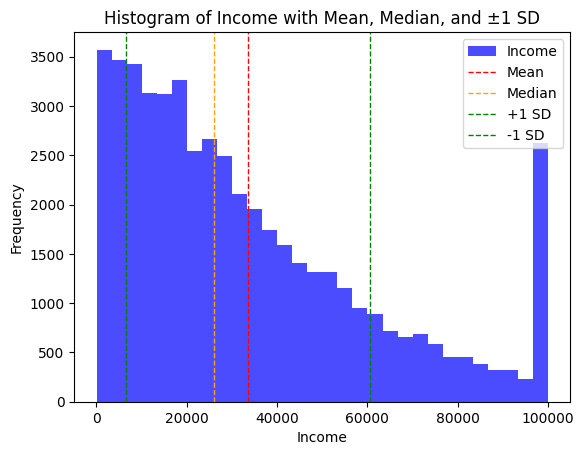

In [6]:
# also add median income
# Calculate mean, median, and standard deviation
mean = df[target].mean()
median = df[target].median()
std = df[target].std()

# Plot histogram
plt.hist(df[target], bins=30, alpha=0.7, color='blue', label='Income')

# Add mean, median, and ±1 standard deviation lines
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Median')
plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label='+1 SD')
plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1, label='-1 SD')

# Add labels and legend
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Histogram of Income with Mean, Median, and ±1 SD')
plt.legend()

# Show plot
plt.show()

In [7]:
df[target].describe()

count    49531.000000
mean     33509.843129
std      27051.436074
min        107.000000
25%      12027.000000
50%      26013.000000
75%      48457.500000
max      99999.000000
Name: income, dtype: float64

In [8]:
(df[target]>=50000).sum() / df.shape[0] * 100

np.float64(23.89412691041974)

## DFL vs Logreg, adult income dataset

In [9]:
# filepath = str(processed_data_root() / "adult_recon.csv")
filepath = str(processed_data_root() / "adult_recon26000.csv")
df = pd.read_csv(filepath)

In [10]:
target_col = 'income'
X = df.drop(columns=[target_col])
print(df.shape, X.shape)
print(max(np.linalg.norm(X, ord=2, axis=1)))

B = 1000
X_train, X_test, y_train, y_test = split_data(df=df,target_col=target_col, train_size=B, test_size=B, random_state=42)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

(49531, 100) (49531, 99)
0.9999999999999999


In [11]:
# set(y_train.index) == set(X_train.index), set(y_test.index) == set(X_test.index), set(y_test.index) & set(y_train.index)

In [12]:
lpopt_train = LPOpt(X=X_train, y=y_train)
lpopt_test = LPOpt(X=X_test, y=y_test)

In [13]:
epsilon = 1000
lamb = 0.1
# DFL
dfl = DFL(X_train, y_train, X_test, y_test)
w_dfl = dfl.train_privately(epsilon=epsilon, c=0.01, lamb=lamb)

In [14]:
# TwoStage
two_stage = TwoStage(X_train, y_train, X_test, y_test)
w_lr = two_stage.train_privately(epsilon=epsilon, lamb=lamb)

In [15]:
w_dfl.shape, w_lr.shape

((99,), (99,))

In [16]:
loss_dfl_train, acc_dfl_train, dq_dfl_train = dfl.metrics_train(w_dfl, lpopt_train)
print(loss_dfl_train, acc_dfl_train, dq_dfl_train)

Restricted license - for non-production use only - expires 2026-11-23
inf 0.754 256.0


/home/kacharya33/dp4dfl/src/LogLossAccuracy.py:16: RuntimeWarning: overflow encountered in exp
  loss = np.mean(np.log(1 + np.exp(-z)))
/home/kacharya33/dp4dfl/src/LogLossAccuracy.py:28: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-np.dot(self.X, w)))


In [17]:
loss_dfl_test, acc_dfl_test, dq_dfl_test = dfl.metrics_test(w_dfl, lpopt_test)
print(loss_dfl_test, acc_dfl_test, dq_dfl_test)

inf 0.71 203.0


In [18]:
loss_lr_train, acc_lr_train, dq_lr_train = two_stage.metrics_train(w_lr, lpopt_train)
print(loss_lr_train, acc_lr_train, dq_lr_train)

0.6536293054768518 0.802 304.0


In [19]:
loss_lr_test, acc_lr_test, dq_lr_test = two_stage.metrics_test(w_lr, lpopt_test)
print(loss_lr_test, acc_lr_test, dq_lr_test)

0.6576218965922798 0.748 241.0


In [21]:
resfile = str(output_dir() / "df_vs_lr_multisamples_B1000_eps0.1_c0.1_lambdfl0.1_lamblr0.1.csv")
res = pd.read_csv(resfile)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kacharya33/dp4dfl/outputs/df_vs_lr_multisamples_B1000_eps0.1_c0.1_lambdfl0.1_lamblr0.1.csv'

In [ ]:
res.columns

Index(['run', 'epsilon', 'lamb_dfl', 'c_dfl', 'lamb_lr', 'w_dfl', 'w_lr',
       'trainloss_dfl', 'trainacc_dfl', 'traindq_dfl', 'testloss_dfl',
       'testacc_dfl', 'testdq_dfl', 'trainloss_lr', 'trainacc_lr',
       'traindq_lr', 'testloss_lr', 'testacc_lr', 'testdq_lr'],
      dtype='object')

In [ ]:
print((res['testdq_lr'] <= res['testdq_dfl']).sum() / res.shape[0] * 100,
(res['traindq_lr'] <= res['traindq_dfl']).sum() / res.shape[0] * 100)

44.0 41.0


In [ ]:
resfile = str(output_dir() / "df_vs_lr_multisamples_B1000_eps0.1_c0.01_lambdfl0.1_lamblr0.1.csv")
res = pd.read_csv(resfile)

In [ ]:
print((res['testdq_lr'] <= res['testdq_dfl']).sum() / res.shape[0] * 100,
(res['traindq_lr'] <= res['traindq_dfl']).sum() / res.shape[0] * 100)

45.0 44.0


In [ ]:
resfile = str(output_dir() / "df_vs_lr_multisamples_B1000_eps1_c0.01_lambdfl0.1_lamblr0.1.csv")
res = pd.read_csv(resfile)

In [ ]:
print((res['testdq_lr'] <= res['testdq_dfl']).sum() / res.shape[0] * 100,
(res['traindq_lr'] <= res['traindq_dfl']).sum() / res.shape[0] * 100)

1.0 0.0


In [ ]:
(res['traindq_lr'] <= res['traindq_dfl']).sum() / res.shape[0] * 100

np.float64(0.0)

In [ ]:
resfile = str(output_dir() / "df_vs_lr_multisamples_B1000_eps1_c0.1_lambdfl0.1_lamblr0.1.csv")
res = pd.read_csv(resfile)

In [ ]:
(res['traindq_lr'] <= res['traindq_dfl']).sum()

np.int64(3)

In [ ]:
resfile = str(output_dir() / "df_vs_lr_multisamples_B1000_eps1_c1_lambdfl0.1_lamblr0.1.csv")
res = pd.read_csv(resfile)

In [ ]:
(res['traindq_lr'] <= res['traindq_dfl']).sum()

np.int64(0)

## Count number of files in directory ending with csv

In [ ]:
filepath = str(output_dir())

In [ ]:
# Count number of files in directory ending with ipynb
import os
import pandas as pd

# List all files in the directory
files = os.listdir(filepath)

# Filter files ending with .ipynb
ipynb_files = [file for file in files if file.endswith('.csv')]


# Count the number of .ipynb files
print(f"Number of .ipynb files: {len(ipynb_files)}")

# concatenate all the csv files in pandas
df_all = pd.concat([pd.read_csv(os.path.join(filepath, file)) for file in ipynb_files], ignore_index=True)

Number of .ipynb files: 300


In [ ]:
df_all.columns, df_all.head()

(Index(['run', 'key', 'epsilon', 'lamb_dfl', 'c_dfl', 'lamb_lr', 'w_dfl',
        'w_lr', 'trainloss_dfl', 'trainacc_dfl', 'traindq_dfl', 'testloss_dfl',
        'testacc_dfl', 'testdq_dfl', 'trainloss_lr', 'trainacc_lr',
        'traindq_lr', 'testloss_lr', 'testacc_lr', 'testdq_lr'],
       dtype='object'),
    run                              key  epsilon  lamb_dfl  c_dfl  lamb_lr  \
 0    0  eps0.1_c0.1_lambdfl0.1_lamblr10      0.1       0.1    0.1     10.0   
 1    1  eps0.1_c0.1_lambdfl0.1_lamblr10      0.1       0.1    0.1     10.0   
 2    2  eps0.1_c0.1_lambdfl0.1_lamblr10      0.1       0.1    0.1     10.0   
 3    3  eps0.1_c0.1_lambdfl0.1_lamblr10      0.1       0.1    0.1     10.0   
 4    4  eps0.1_c0.1_lambdfl0.1_lamblr10      0.1       0.1    0.1     10.0   
 
           w_dfl      w_lr  trainloss_dfl  trainacc_dfl  traindq_dfl  \
 0  1.127575e+07  0.187457            inf         0.493         -5.0   
 1  1.419214e+07  0.175073            inf         0.437        -61.0 

In [ ]:
(df_all['testdq_dfl'] > df_all['testdq_lr']).sum() / df_all.shape[0] * 100 # 16 percent of all cases

len(df_all['key'].unique())

percent = []
for k in df_all['key'].unique(): # check case by case for each key in which dfl is better
    df_k = df_all[df_all['key'] == k]
    percent.append( (k, (df_k['testdq_dfl'] >= df_k['testdq_lr']).sum() / df_k.shape[0] * 100))

sorted_k = sorted(percent, key=lambda x: x[1], reverse=True)

In [ ]:
import os
import pandas as pd
filepath = str(output_dir_name('v2'))

# List all files in the directory
files = os.listdir(filepath)

# Filter files ending with .ipynb
ipynb_files = [file for file in files if file.endswith('.csv')]


# Count the number of .ipynb files
print(f"Number of .ipynb files: {len(ipynb_files)}")

# concatenate all the csv files in pandas
df_all = pd.concat([pd.read_csv(os.path.join(filepath, file)) for file in ipynb_files], ignore_index=True)

print((df_all['testdq_dfl'] > df_all['testdq_lr']).sum() / df_all.shape[0] * 100)


len(df_all['key'].unique())

percent = []
for k in df_all['key'].unique(): # check case by case for each key in which dfl is better
    df_k = df_all[df_all['key'] == k]
    percent.append( (k, (df_k['testdq_dfl'] >= df_k['testdq_lr']).sum() / df_k.shape[0] * 100))

sorted_k = sorted(percent, key=lambda x: x[1], reverse=True)

Number of .ipynb files: 300
16.16


In [ ]:
k = 'eps0.1_c0.1_lambdfl10_lamblr5'
temp = df_all[df_all['key'] == k]

print((temp['testdq_dfl'] > temp['testdq_lr']).sum()/ temp.shape[0] * 100)
print((temp['traindq_dfl'] > temp['traindq_lr']).sum()/ temp.shape[0] * 100)


47.0
45.0


In [ ]:
sorted_k

### Compare LR to best c in DFL

/home/kacharya33/dp4dfl/outputs/vhigherc
Number of .csv files: 1
Percentage where DFL outperforms LR: 50.38%
Shape of df_plot: (20000, 10)


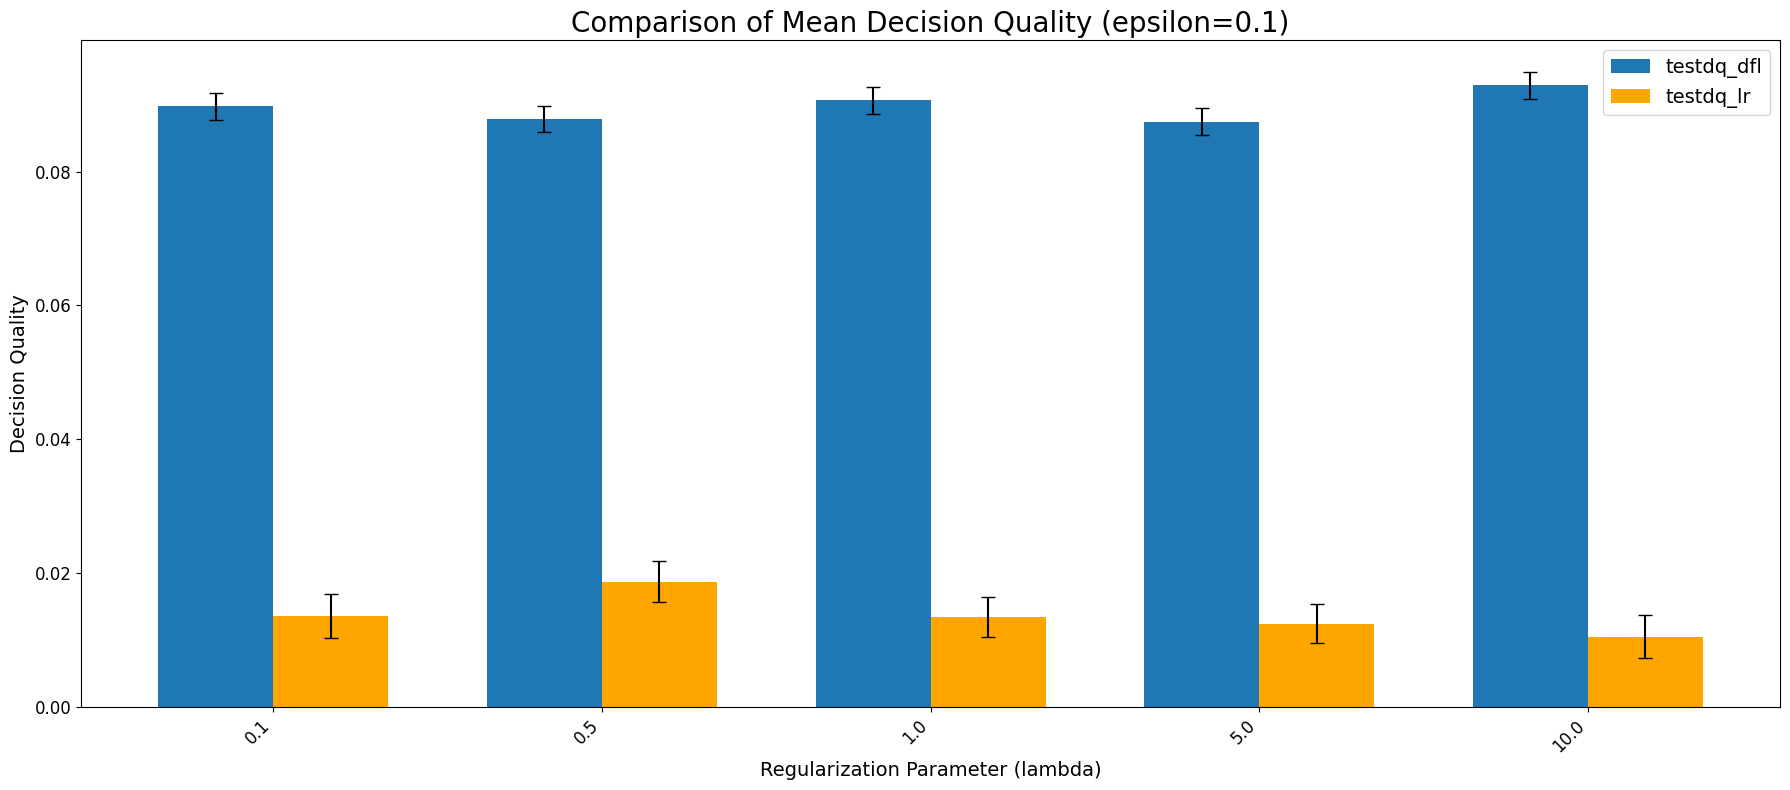

Shape of df_plot: (20000, 10)


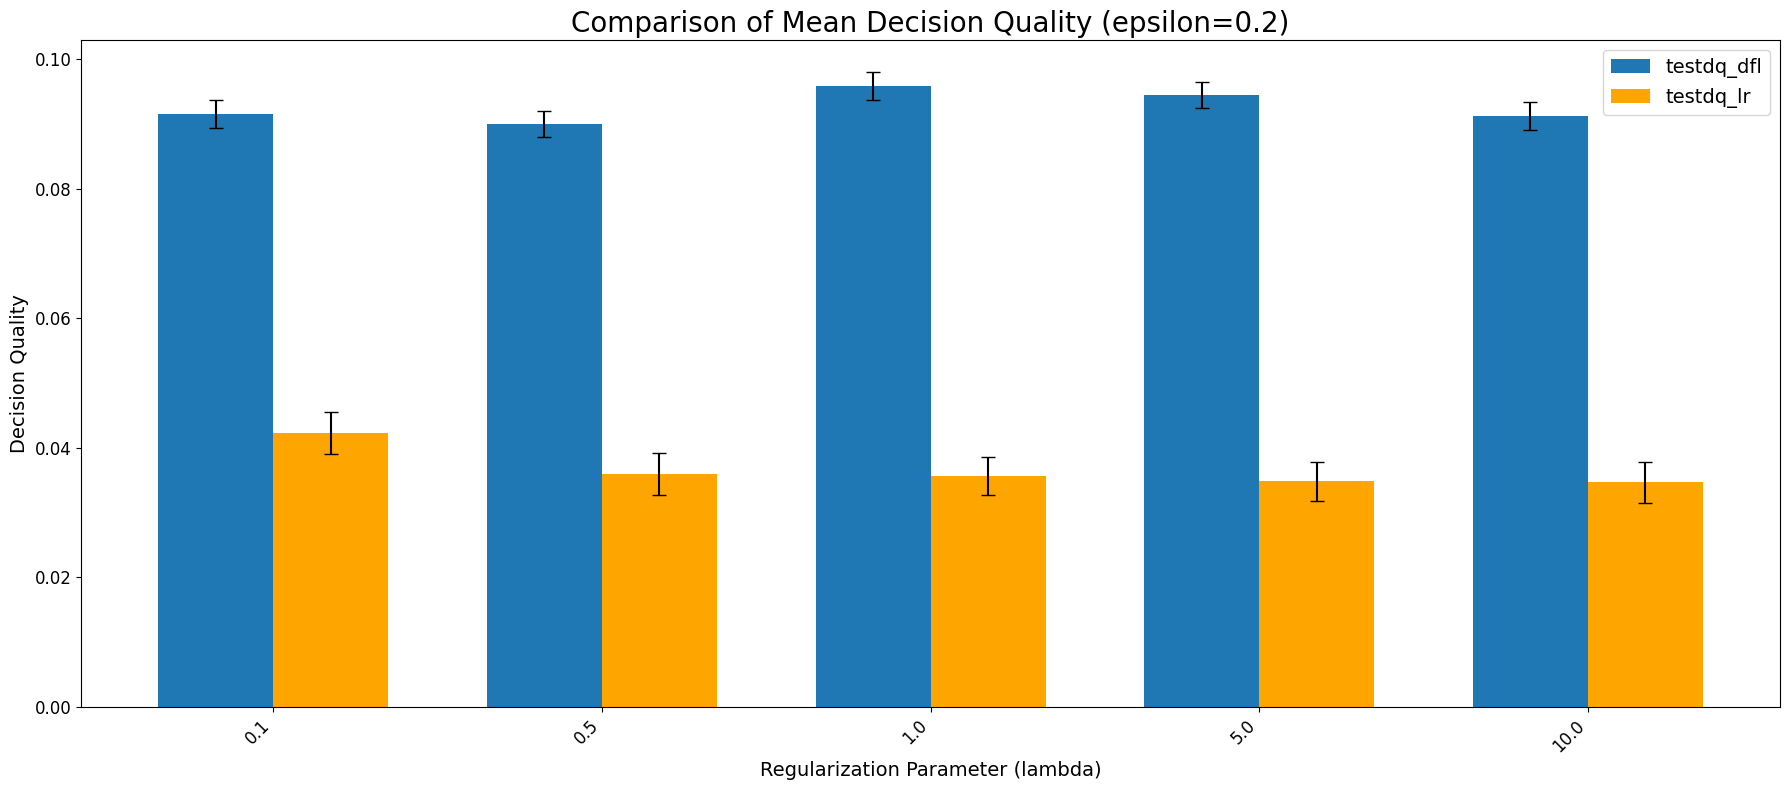

Shape of df_plot: (20000, 10)


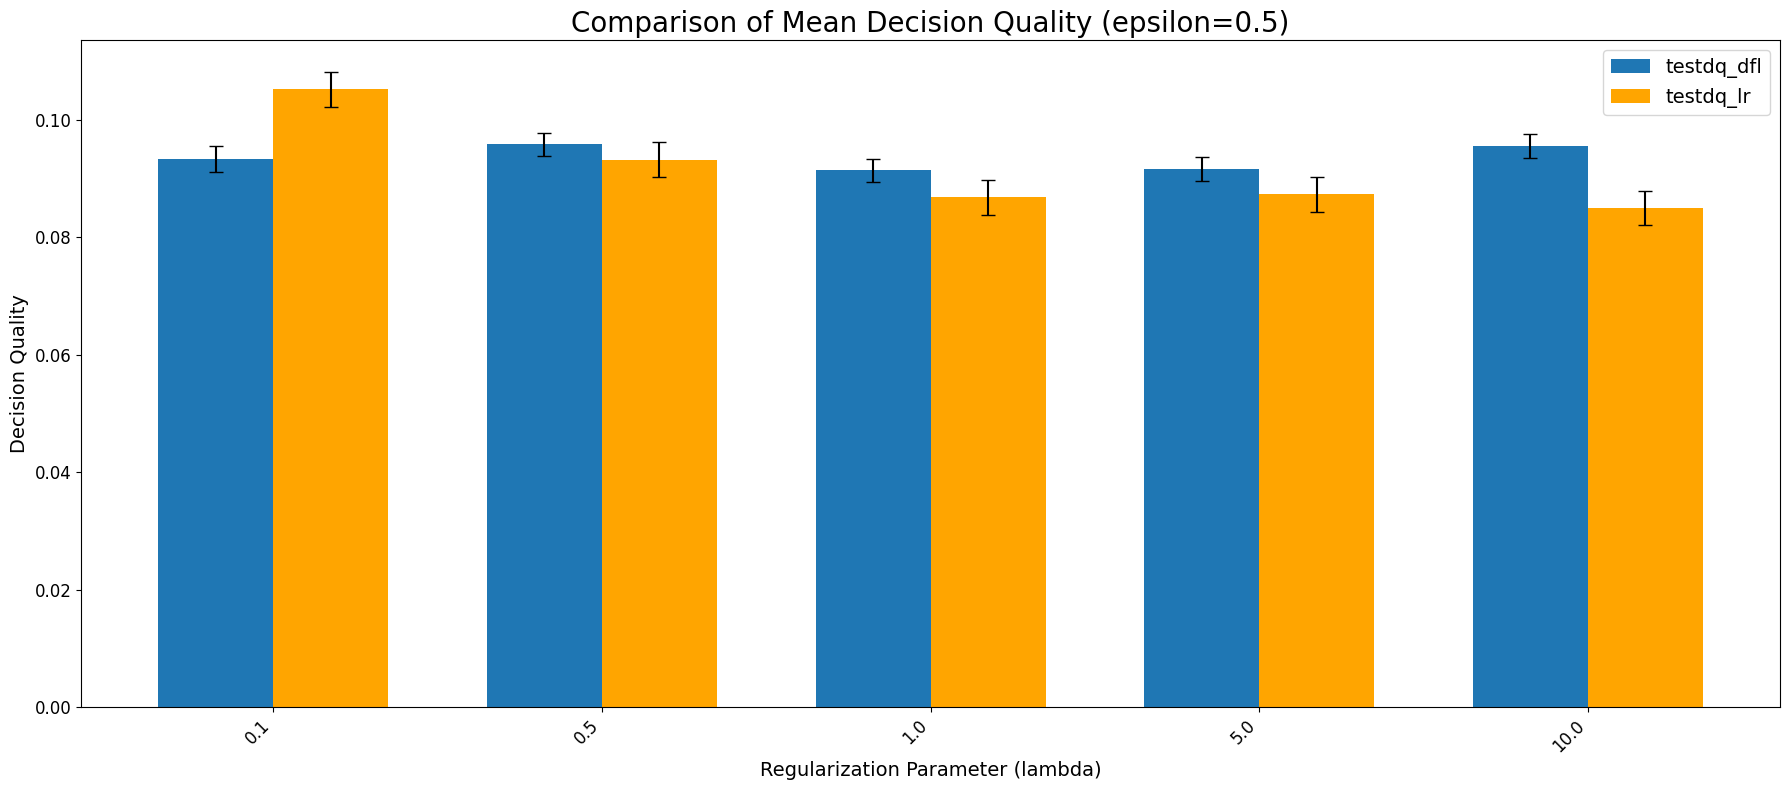

Shape of df_plot: (20000, 10)


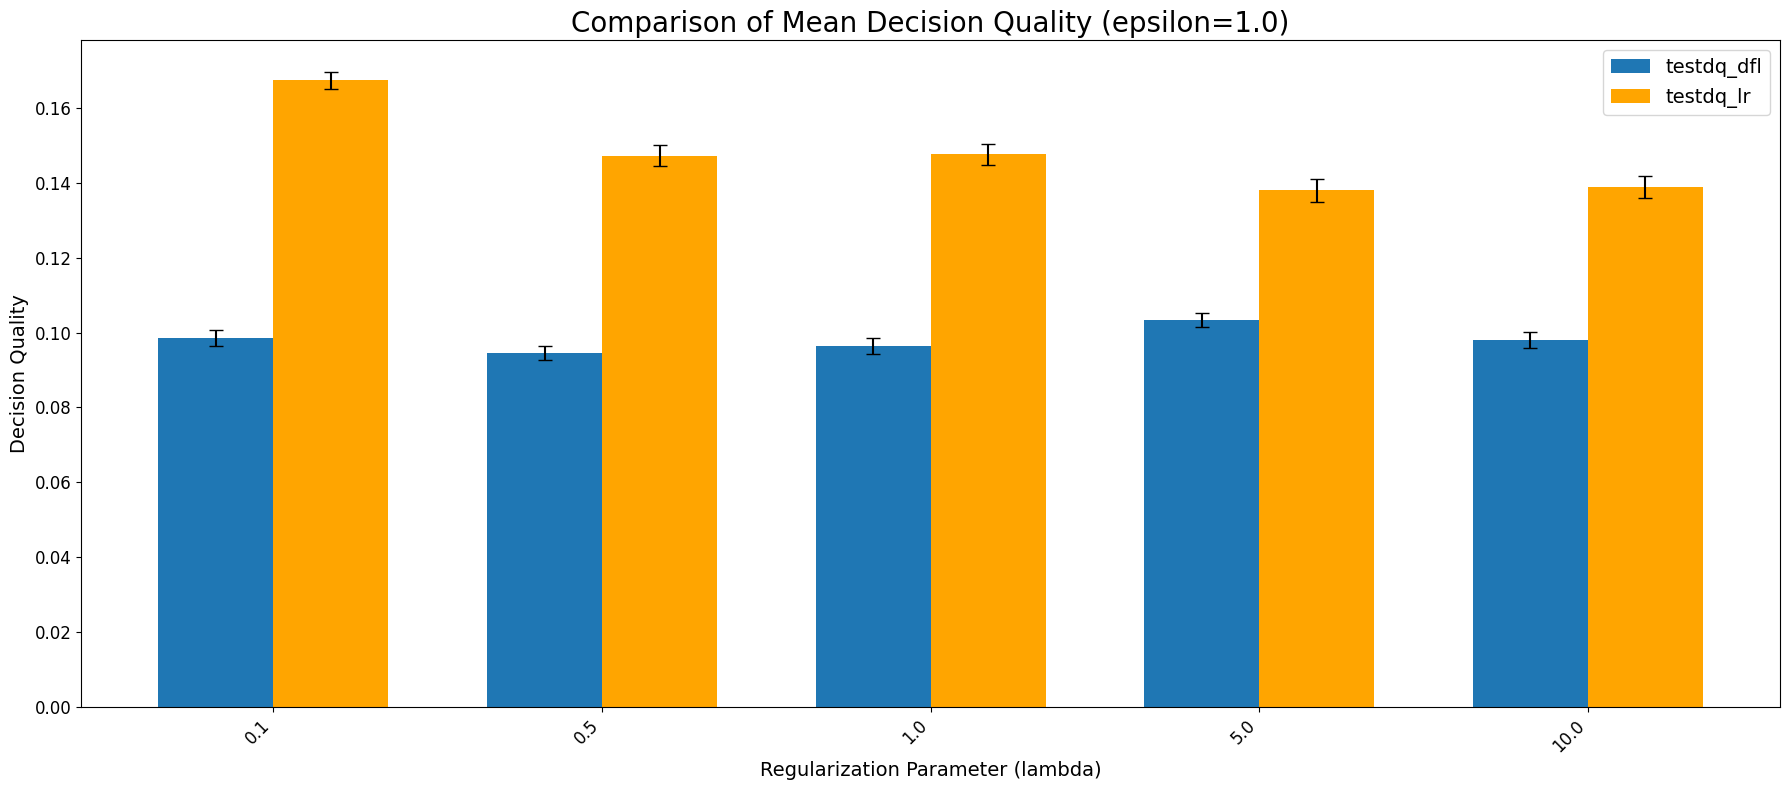

Shape of df_plot: (20000, 10)


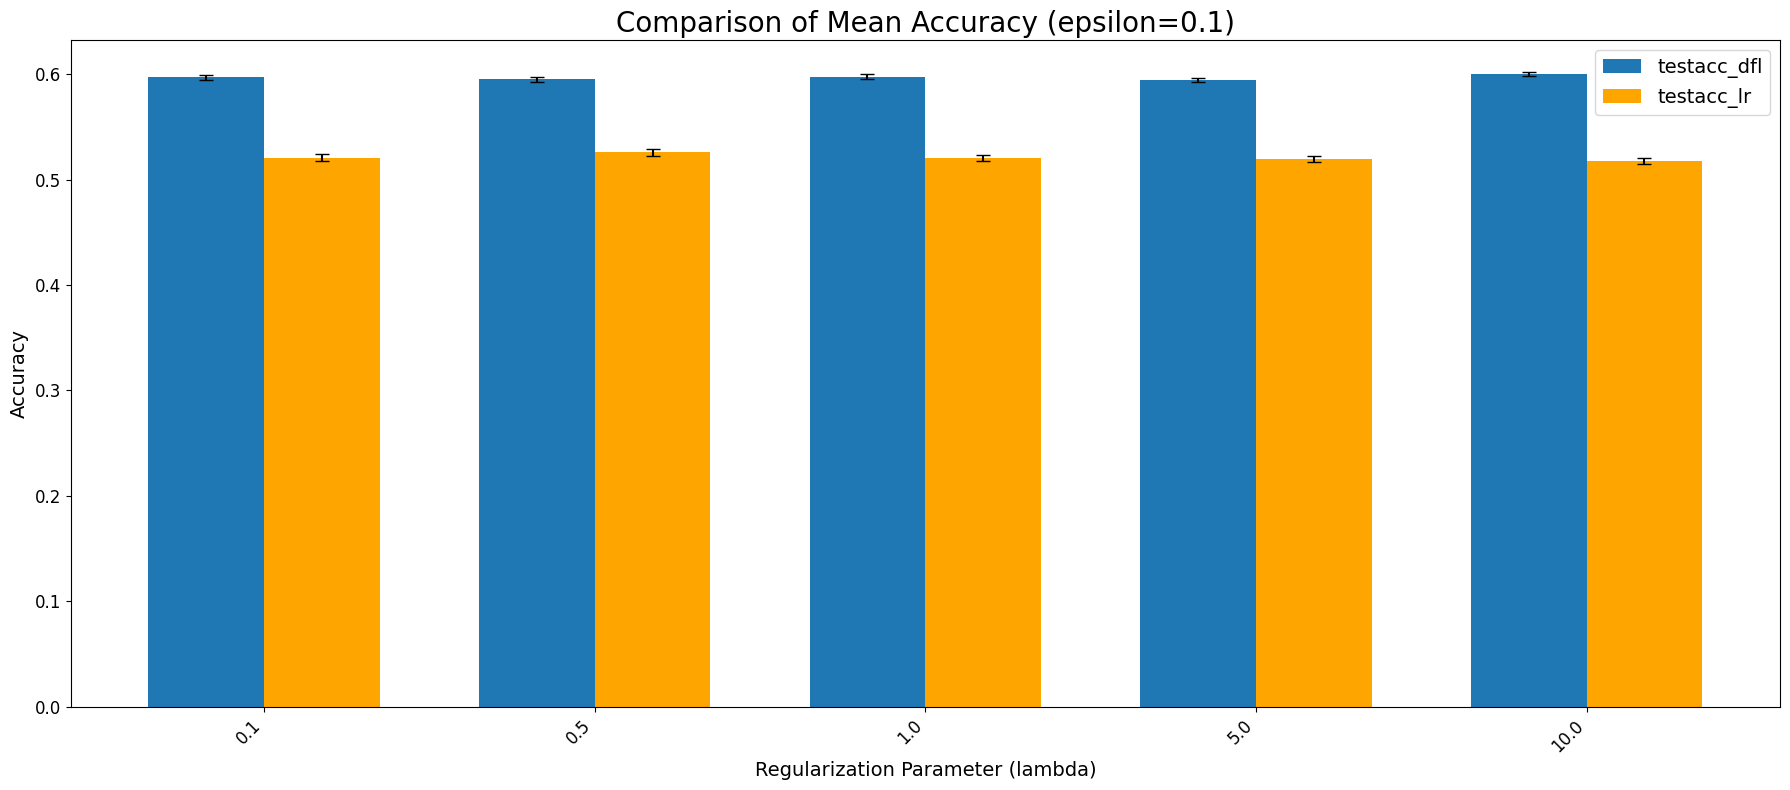

Shape of df_plot: (20000, 10)


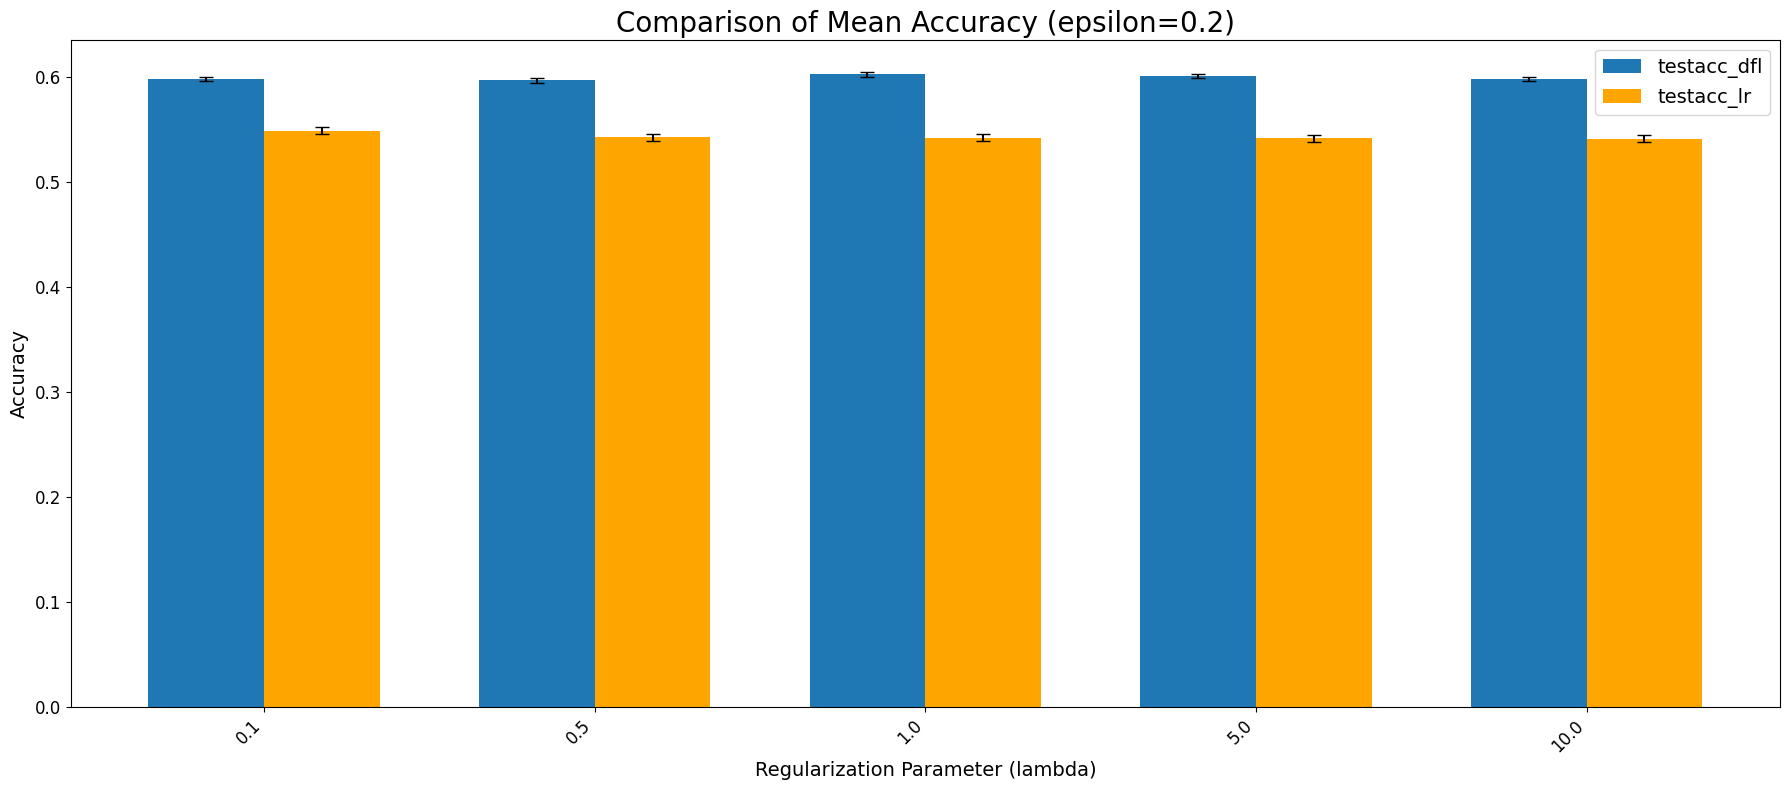

Shape of df_plot: (20000, 10)


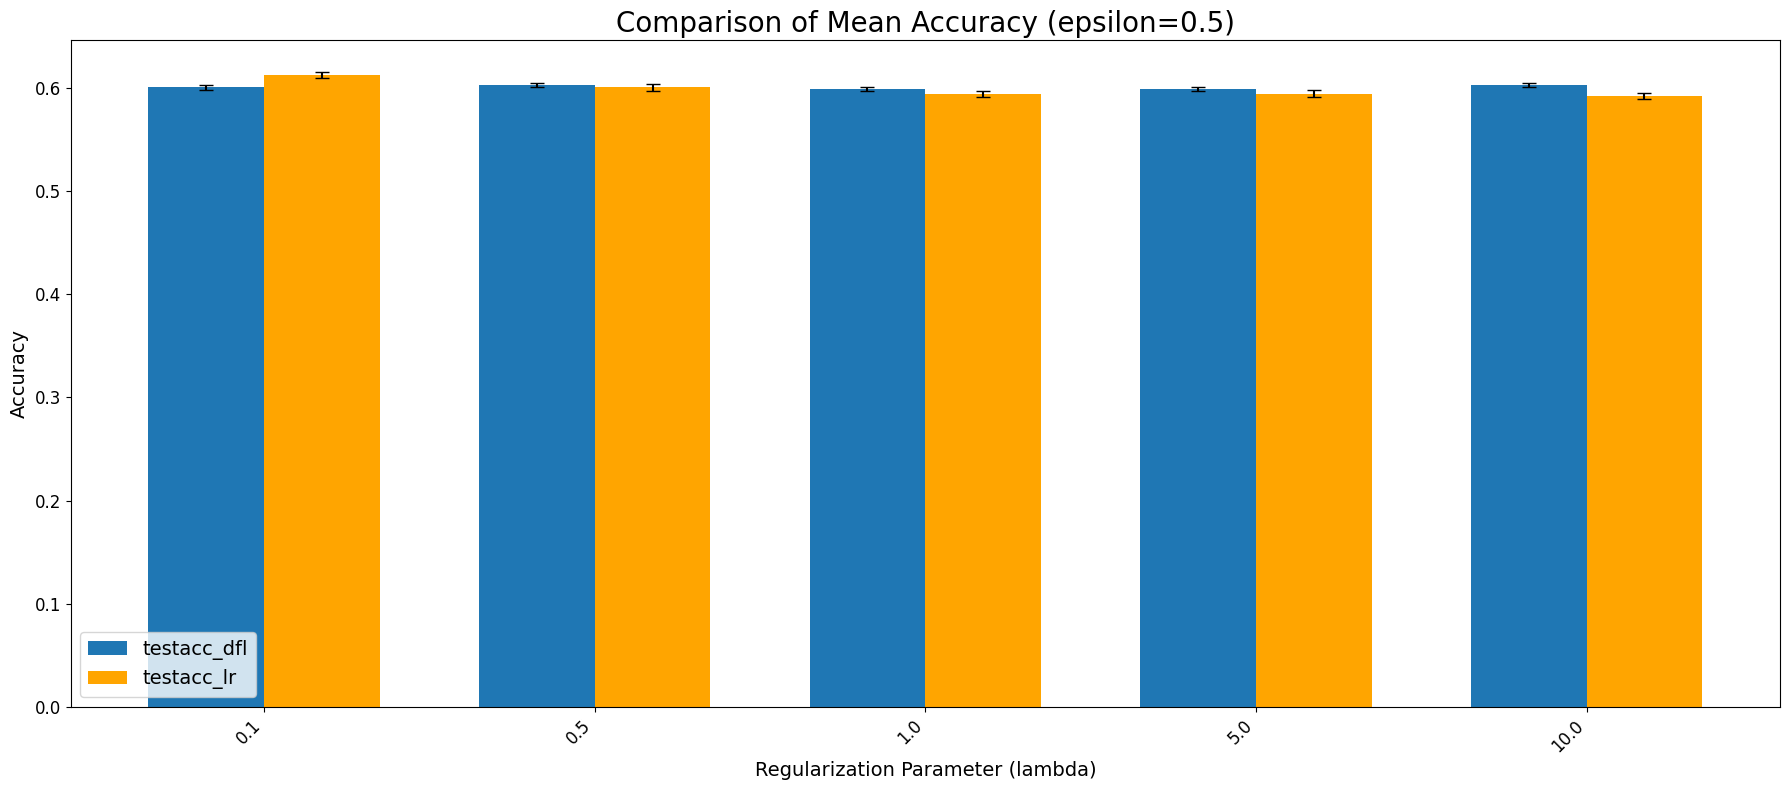

Shape of df_plot: (20000, 10)


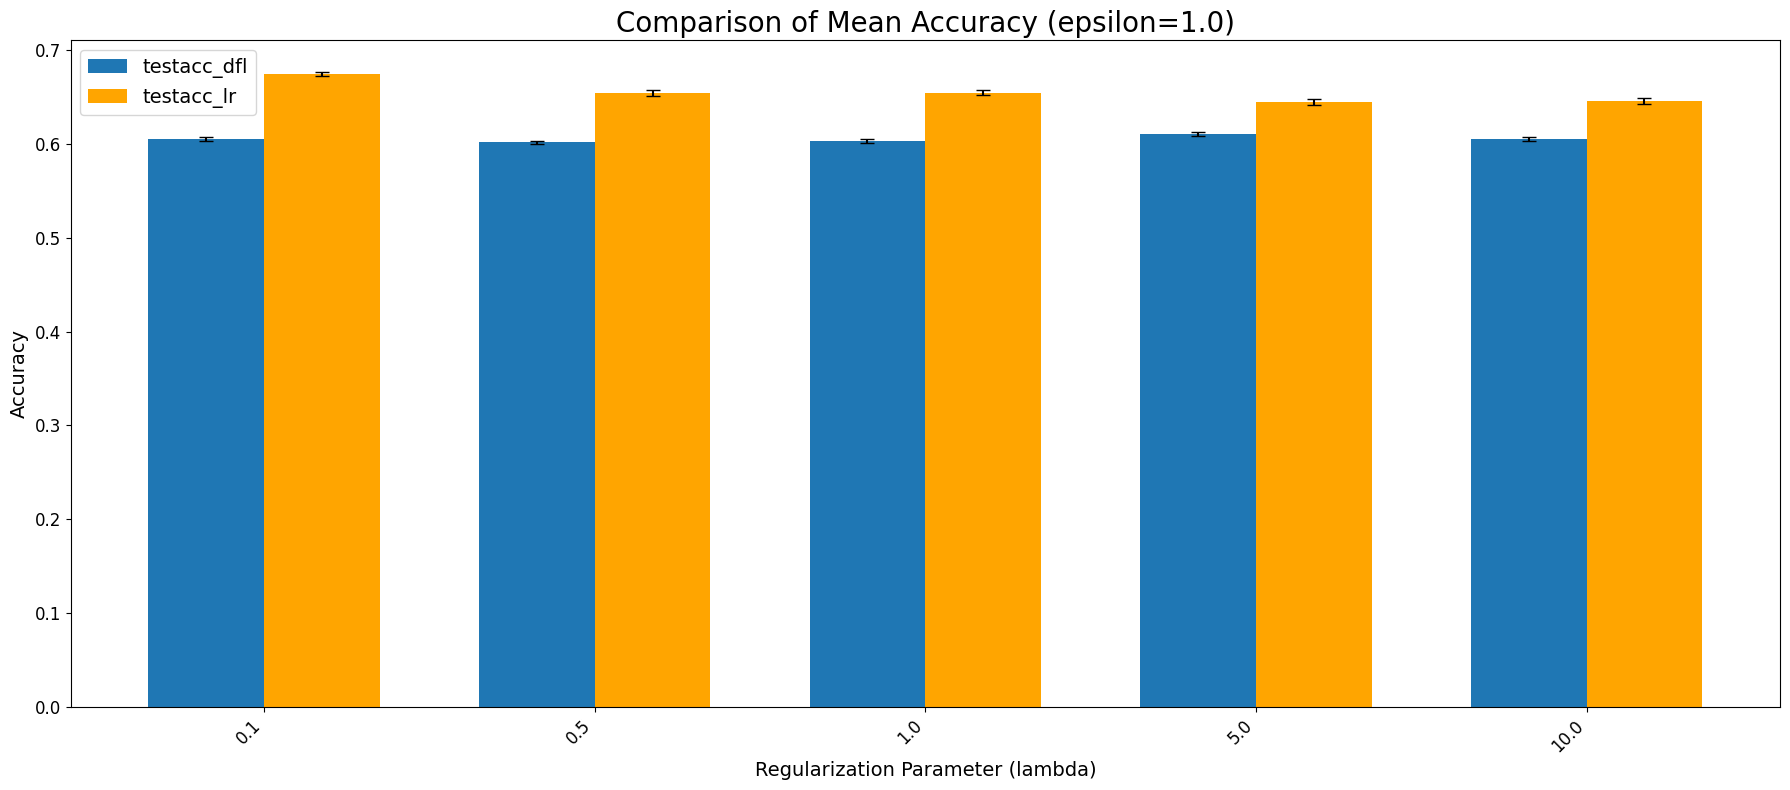

Shape of df_plot: (20000, 10)


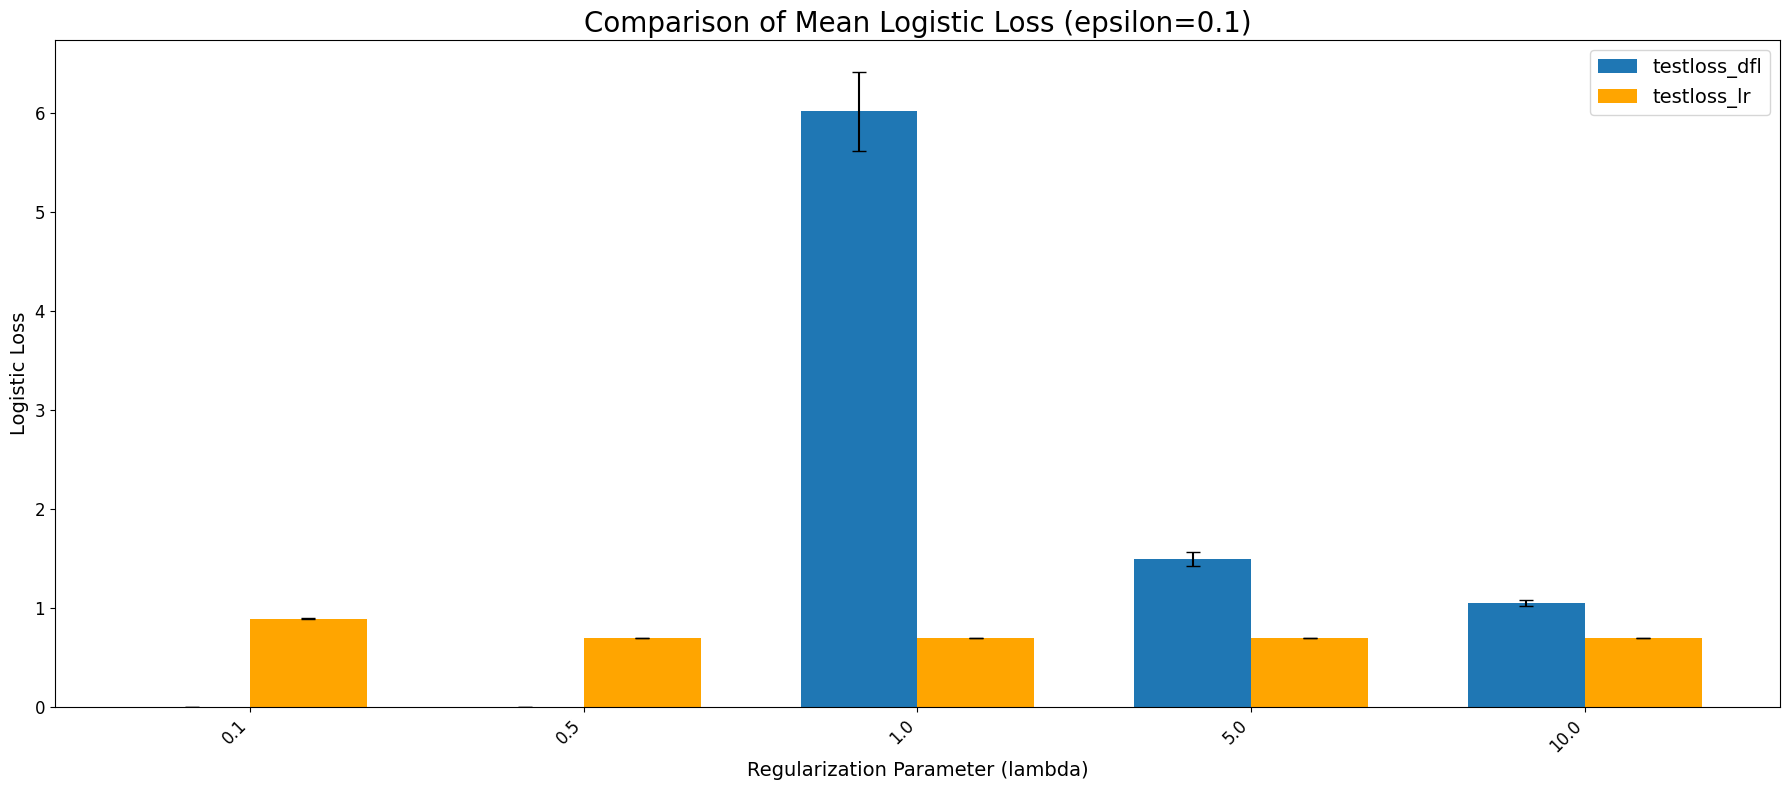

Shape of df_plot: (20000, 10)


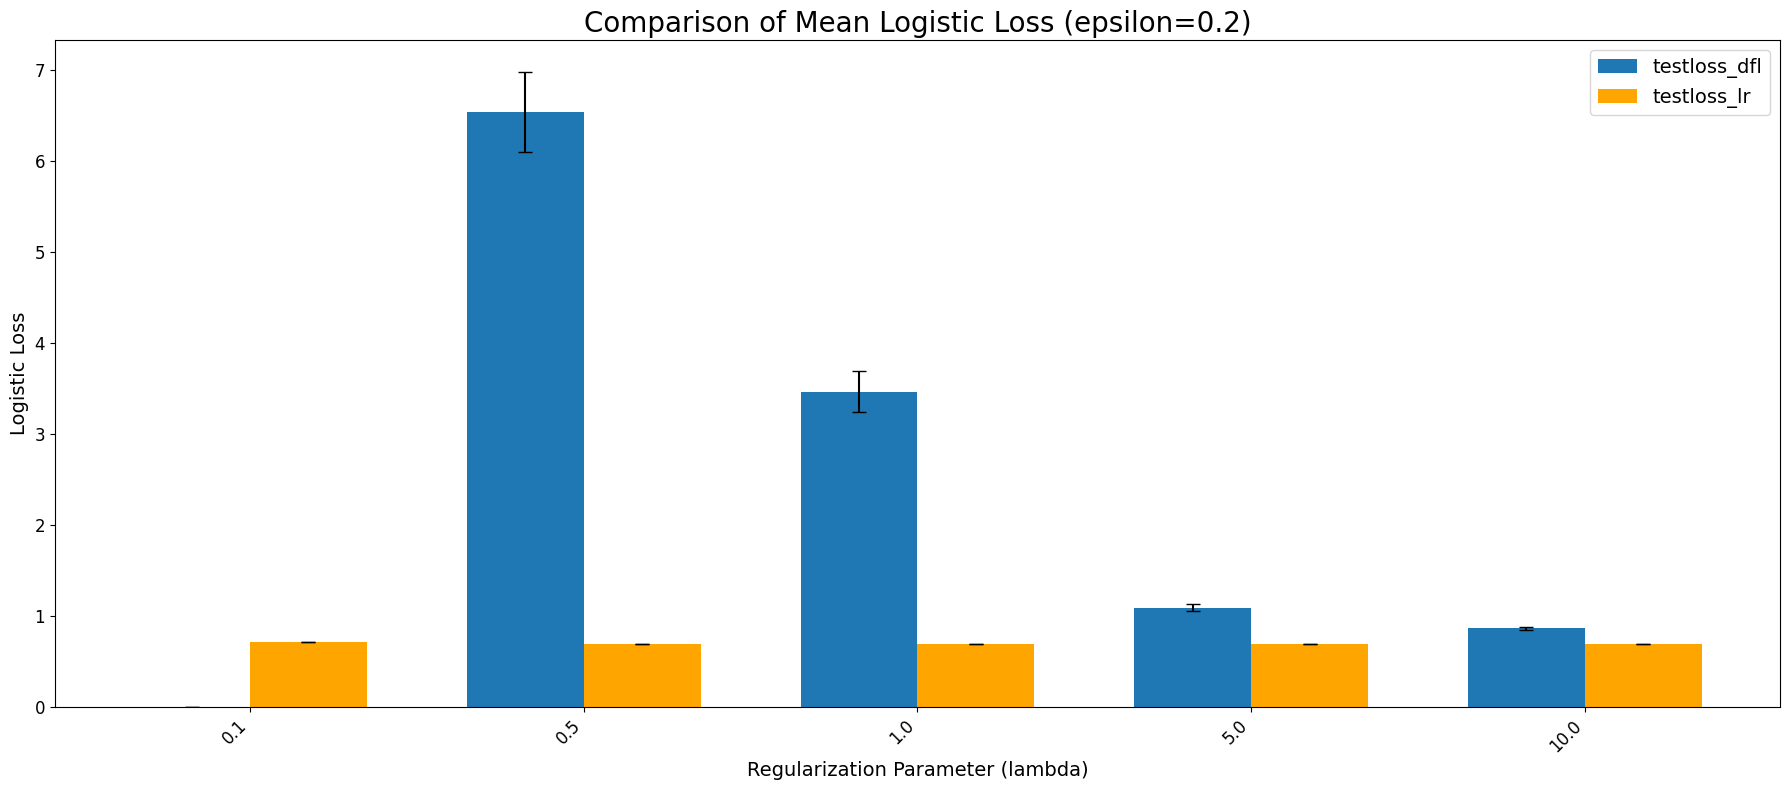

Shape of df_plot: (20000, 10)


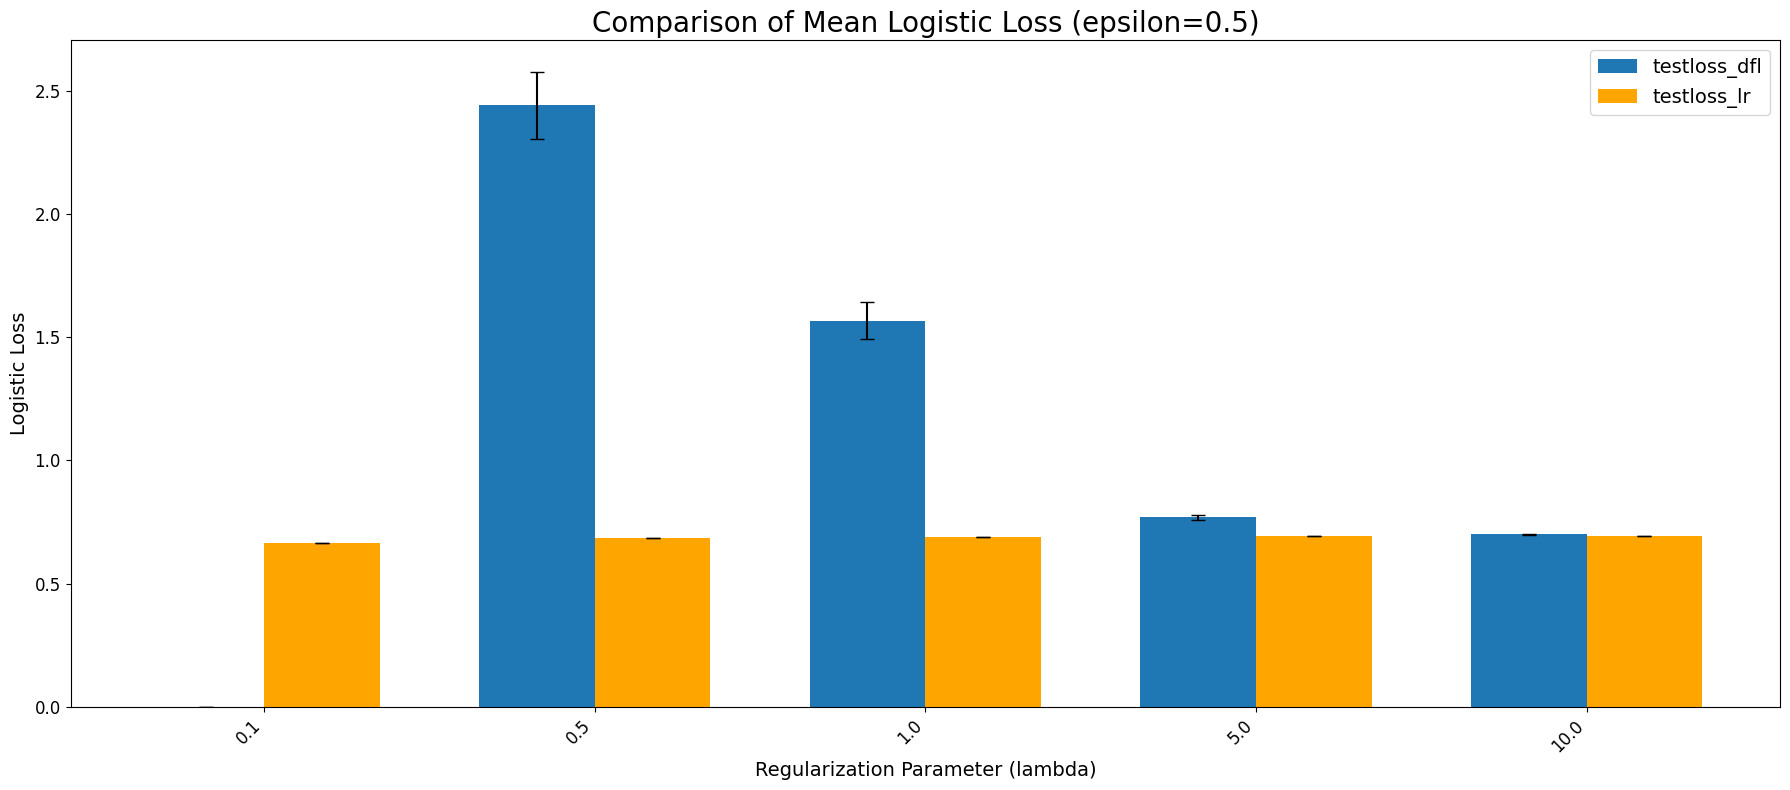

Shape of df_plot: (20000, 10)


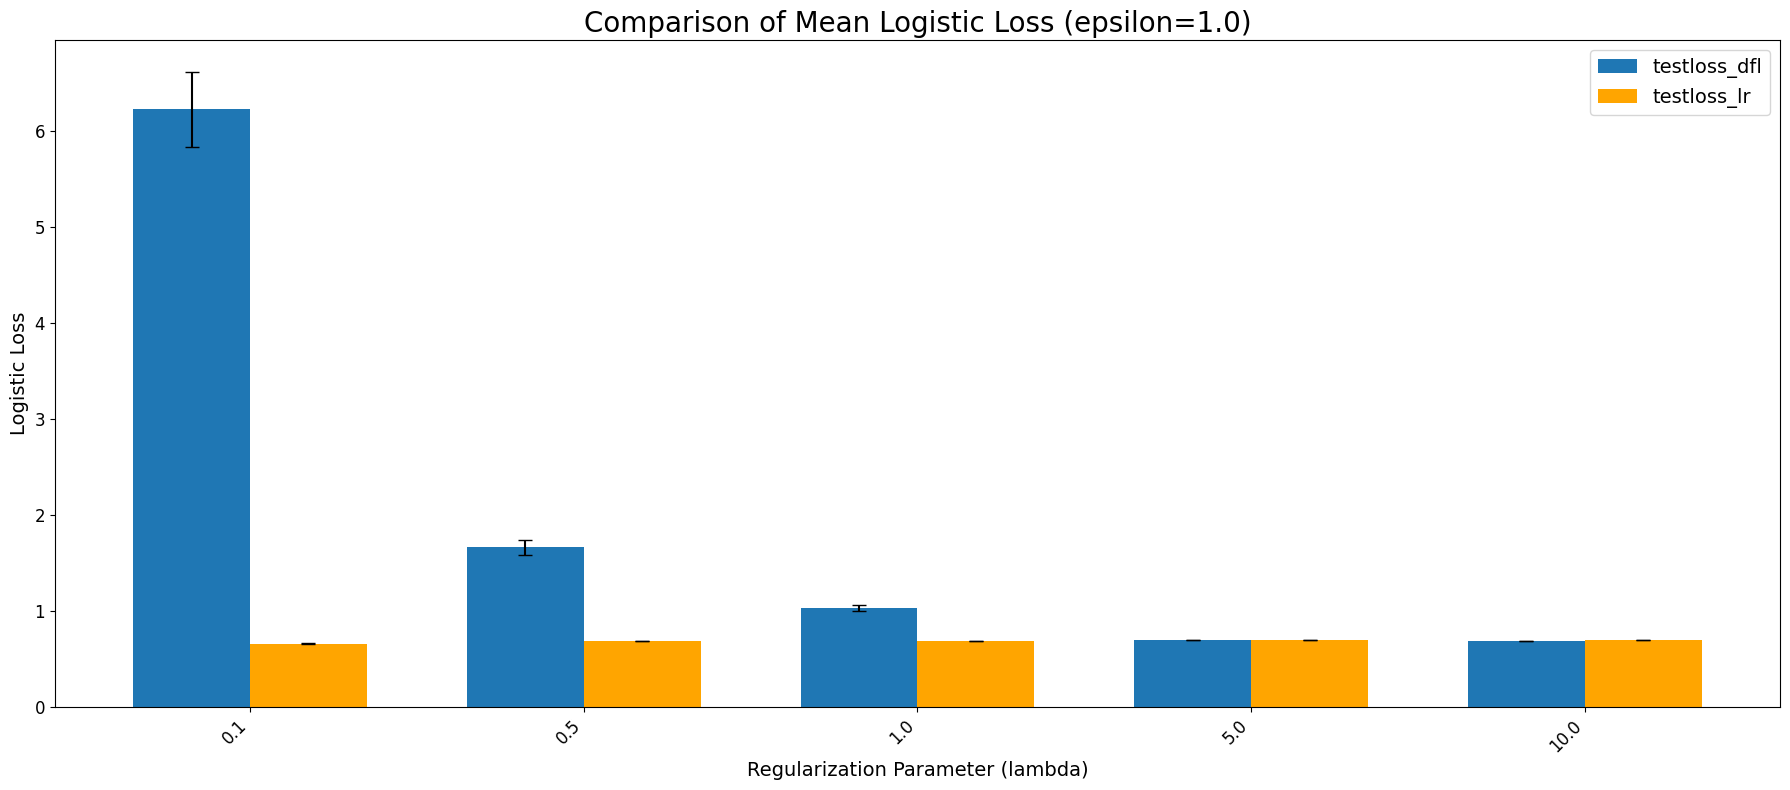

In [4]:
# SBATCH RESULTS
import os
import pandas as pd
from src.project_dirs import output_dir_name
from src.utils import plot_grouped_dq

filepath = str(output_dir_name('vhigherc'))
print(filepath)

# List all files in the directory
files = os.listdir(filepath)
csv_files = [file for file in files if file.endswith('.csv')]
print(f"Number of .csv files: {len(csv_files)}")

file = os.path.join(filepath, csv_files[0])
df_all = pd.read_csv(file)

percentage = (df_all['testdq_dfl'] > df_all['testdq_lr']).mean() * 100
print(f"Percentage where DFL outperforms LR: {percentage:.2f}%")

percent = []
for k in df_all['key'].unique(): # check case by case for each key in which dfl is better
    df_k = df_all[df_all['key'] == k]
    percent.append((k, (df_k['testdq_dfl'] >= df_k['testdq_lr']).sum() / df_k.shape[0] * 100))

sorted_k = sorted(percent, key=lambda x: x[1], reverse=True)

cols_to_use = ['epsilon', 'lamb_dfl', 'lamb_lr', 'c_dfl', 'testloss_dfl', 'testdq_dfl', 'testloss_lr', 'testdq_lr', 'testacc_dfl', 'testacc_lr']

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)


# Plot accuracy
plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)


# Plot loss
plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)





Shape of df_plot: (19900, 6)


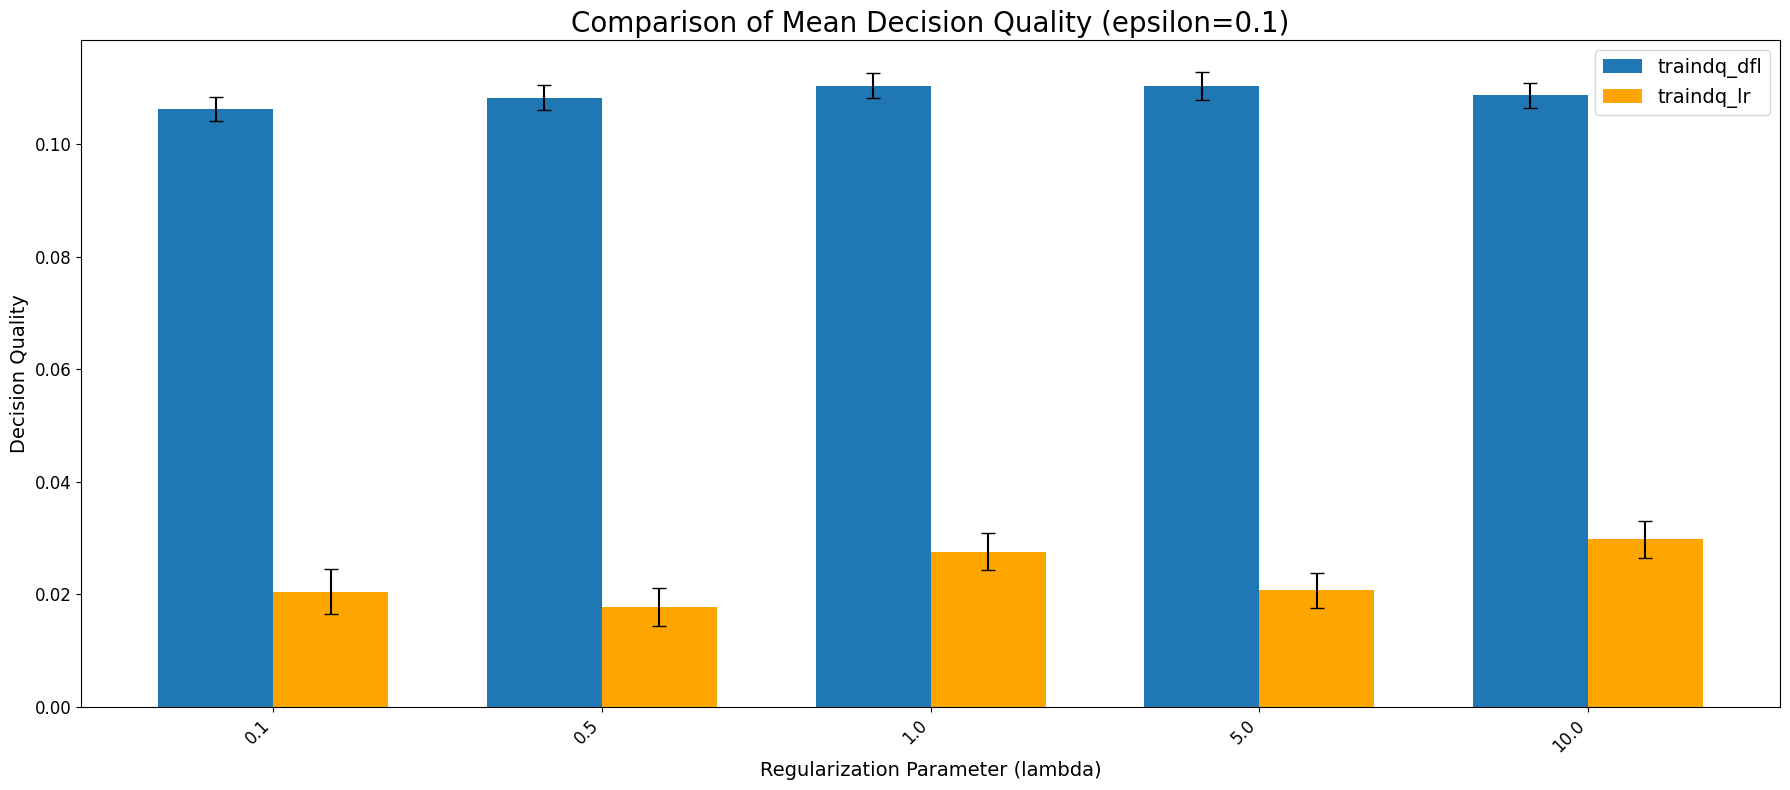

Shape of df_plot: (19900, 6)


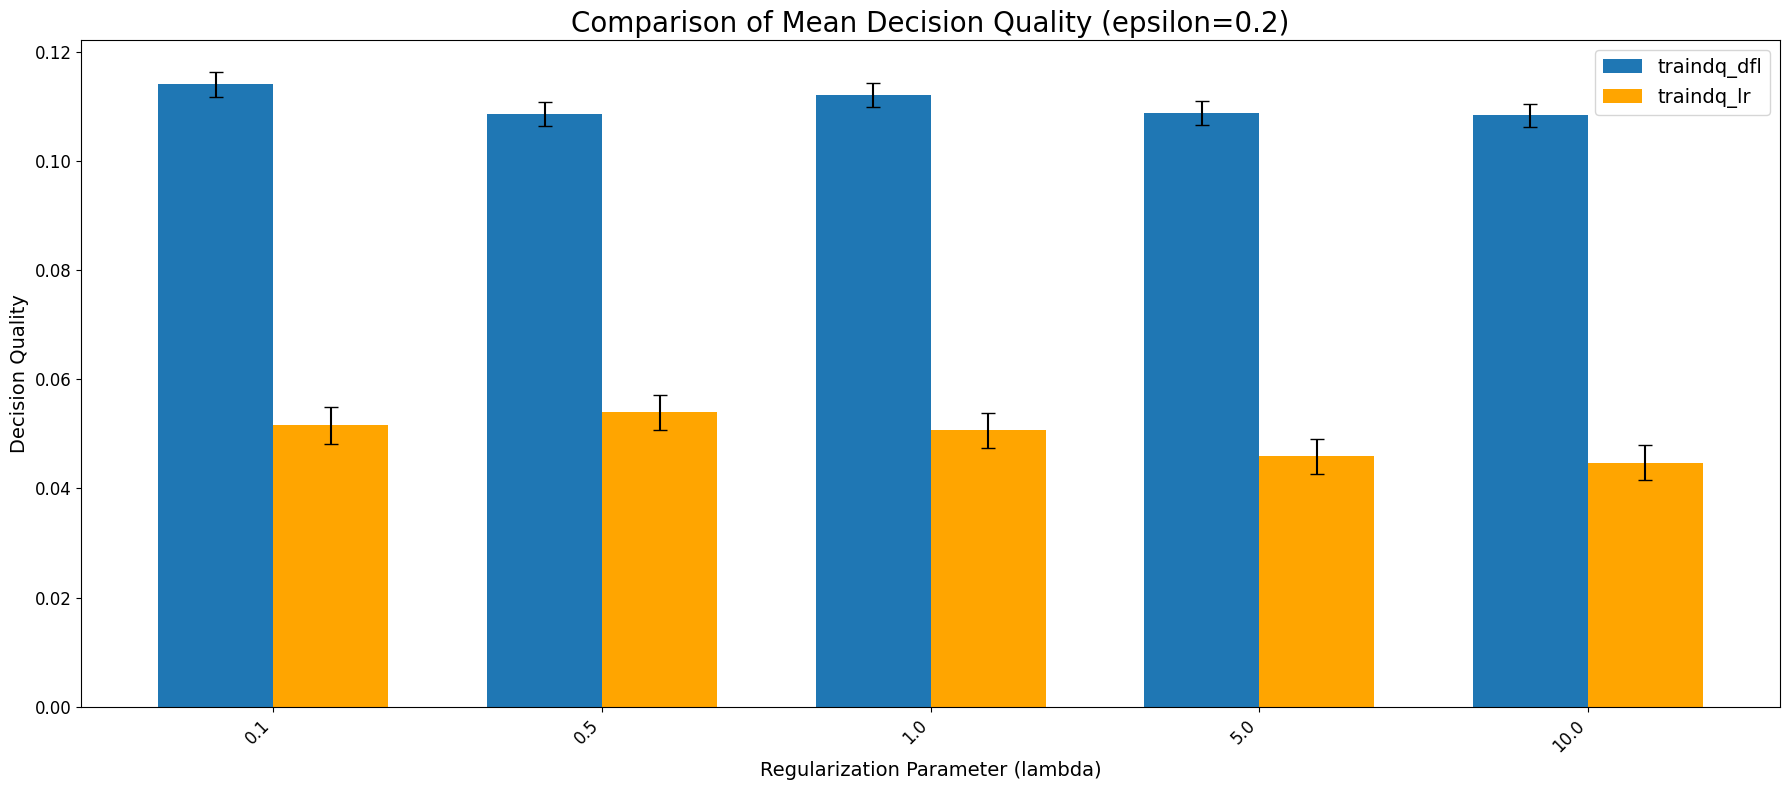

Shape of df_plot: (19900, 6)


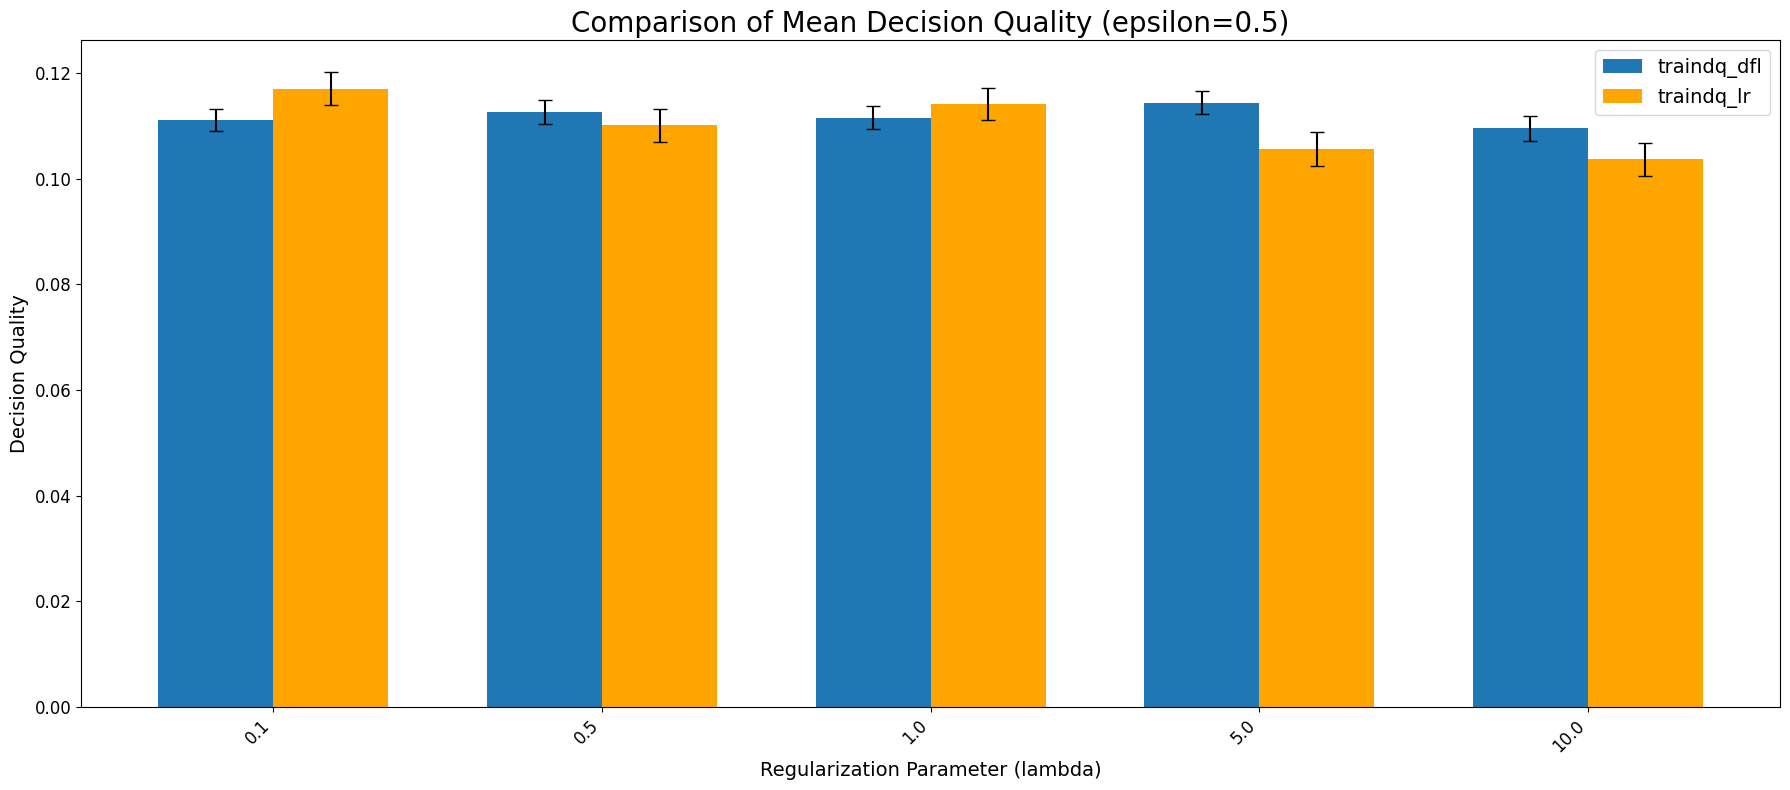

Shape of df_plot: (19900, 6)


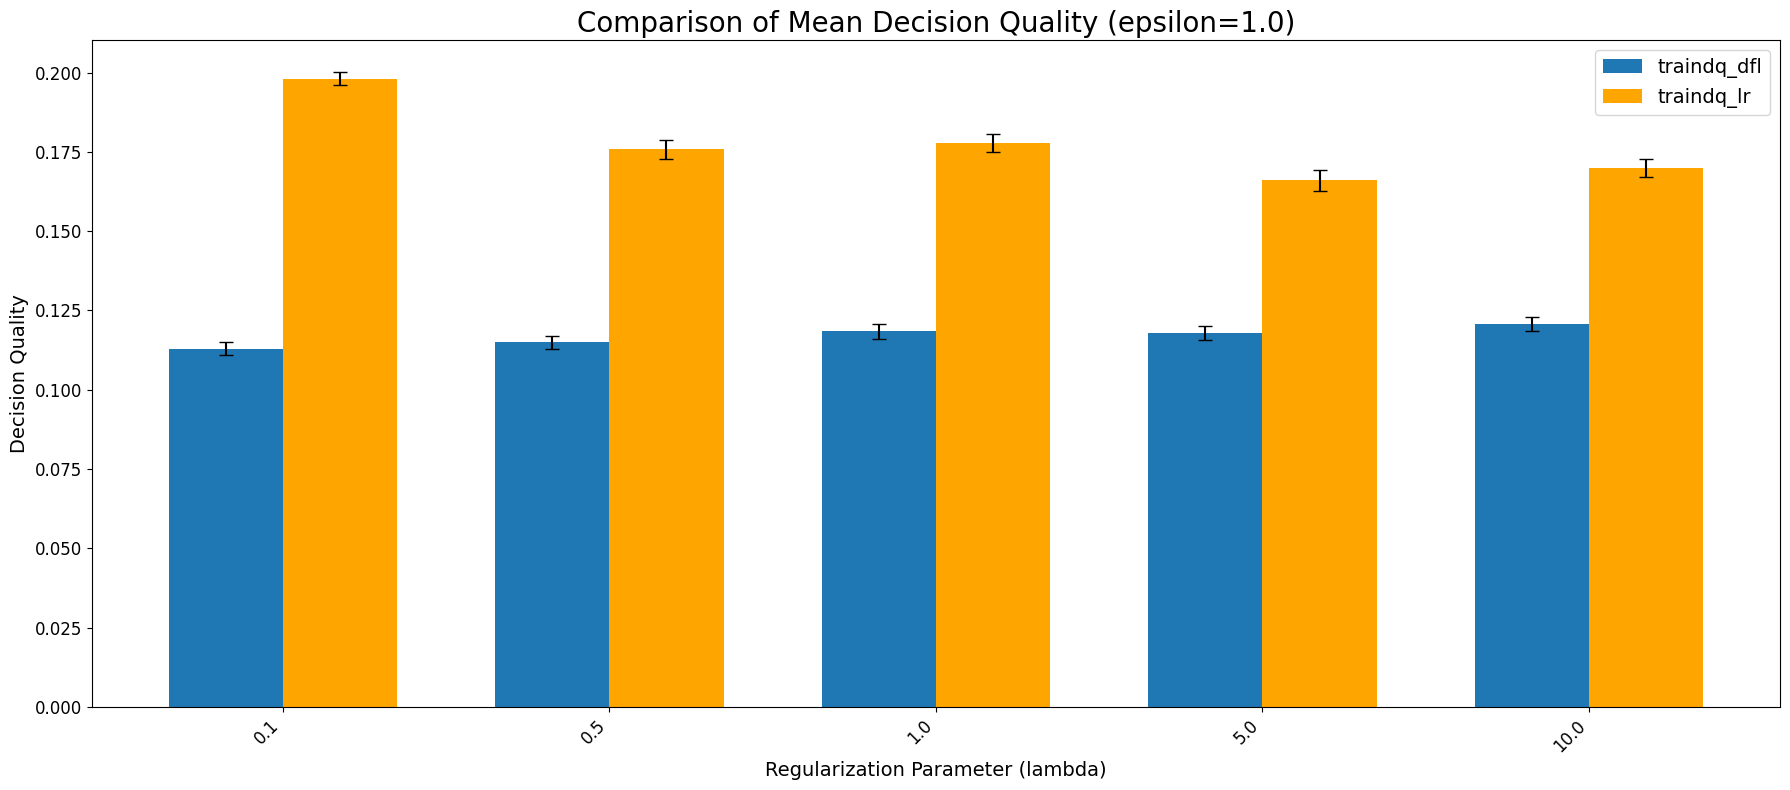

In [15]:
cols_to_use = ['epsilon', 'lamb_dfl', 'lamb_lr', 'c_dfl', 'traindq_dfl', 'traindq_lr']

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'traindq_dfl', 'lamb_lr', 'traindq_lr', metric='Decision Quality', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'traindq_dfl', 'lamb_lr', 'traindq_lr', metric='Decision Quality', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'traindq_dfl', 'lamb_lr', 'traindq_lr', metric='Decision Quality', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'traindq_dfl', 'lamb_lr', 'traindq_lr', metric='Decision Quality', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

In [13]:
df_all.columns

Index(['run', 'key', 'epsilon', 'lamb_dfl', 'c_dfl', 'lamb_lr', 'w_dfl',
       'w_lr', 'trainloss_dfl', 'trainacc_dfl', 'traindq_dfl', 'testloss_dfl',
       'testacc_dfl', 'testdq_dfl', 'trainloss_lr', 'trainacc_lr',
       'traindq_lr', 'testloss_lr', 'testacc_lr', 'testdq_lr'],
      dtype='object')

## Results with equivalent c

/home/kacharya33/dp4dfl/outputs/veqnoise_finer
Number of .csv files: 1
Percentage where DFL outperforms LR: 19.24%
Shape of df_plot: (20000, 10)


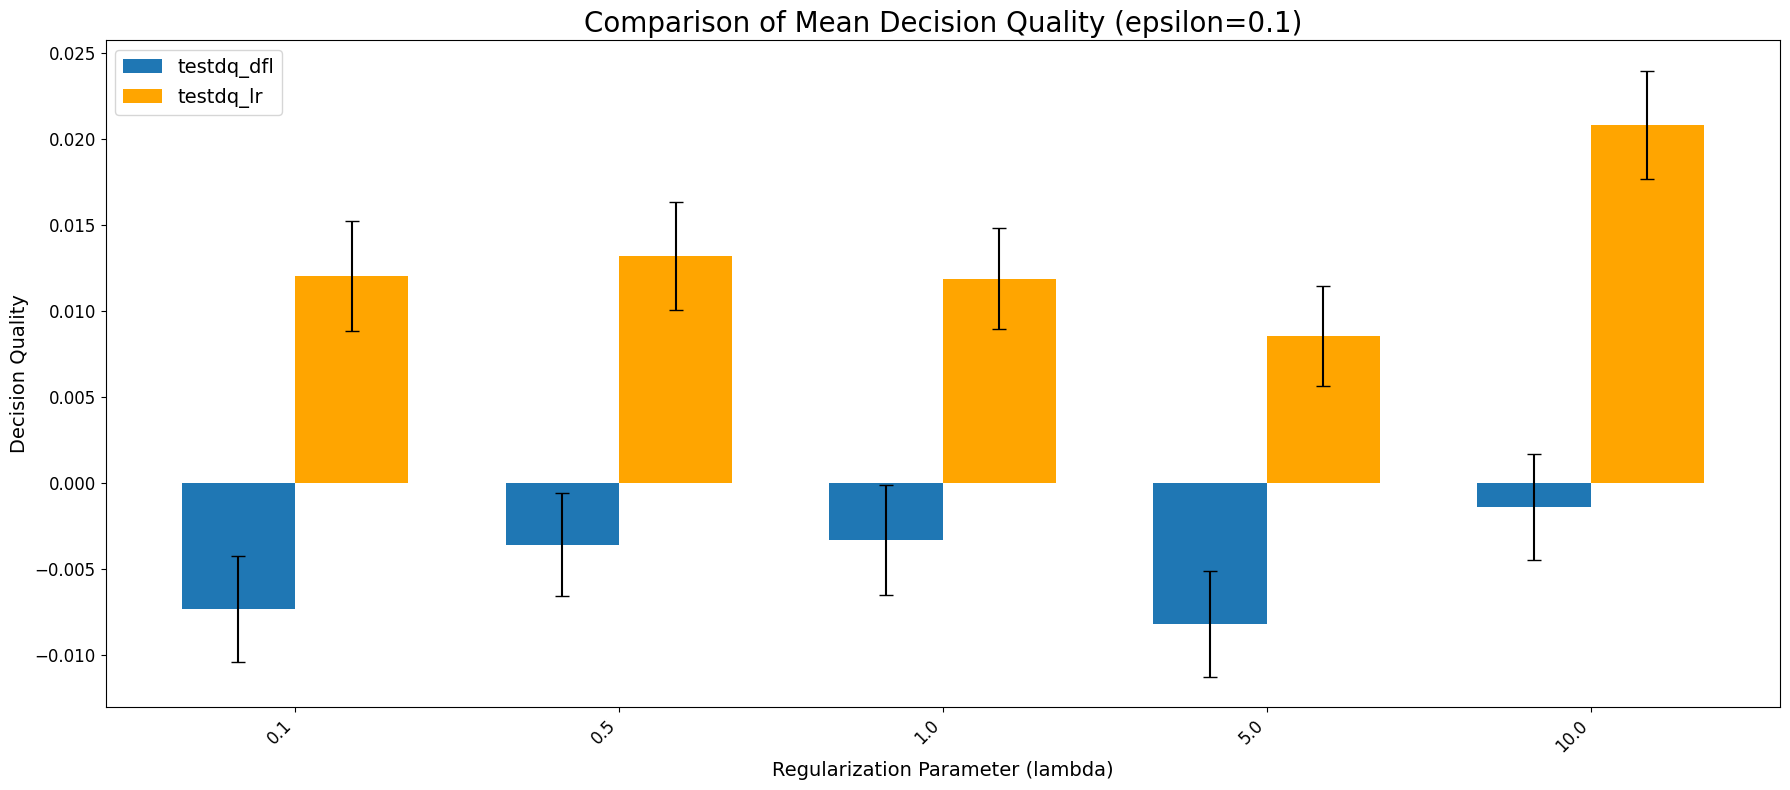

Shape of df_plot: (20000, 10)


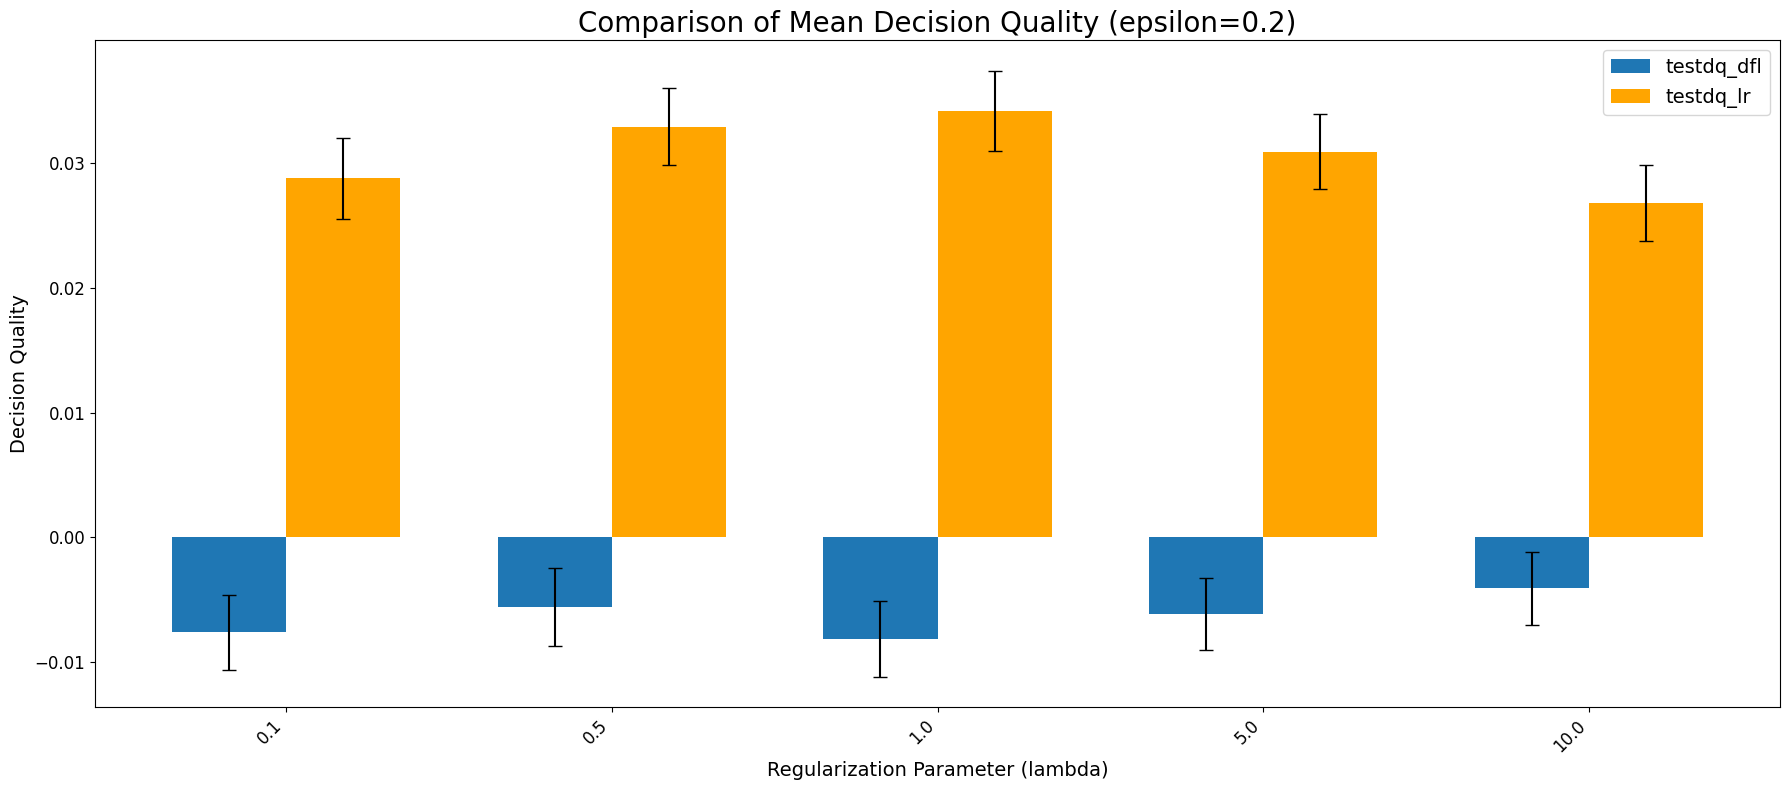

Shape of df_plot: (20000, 10)


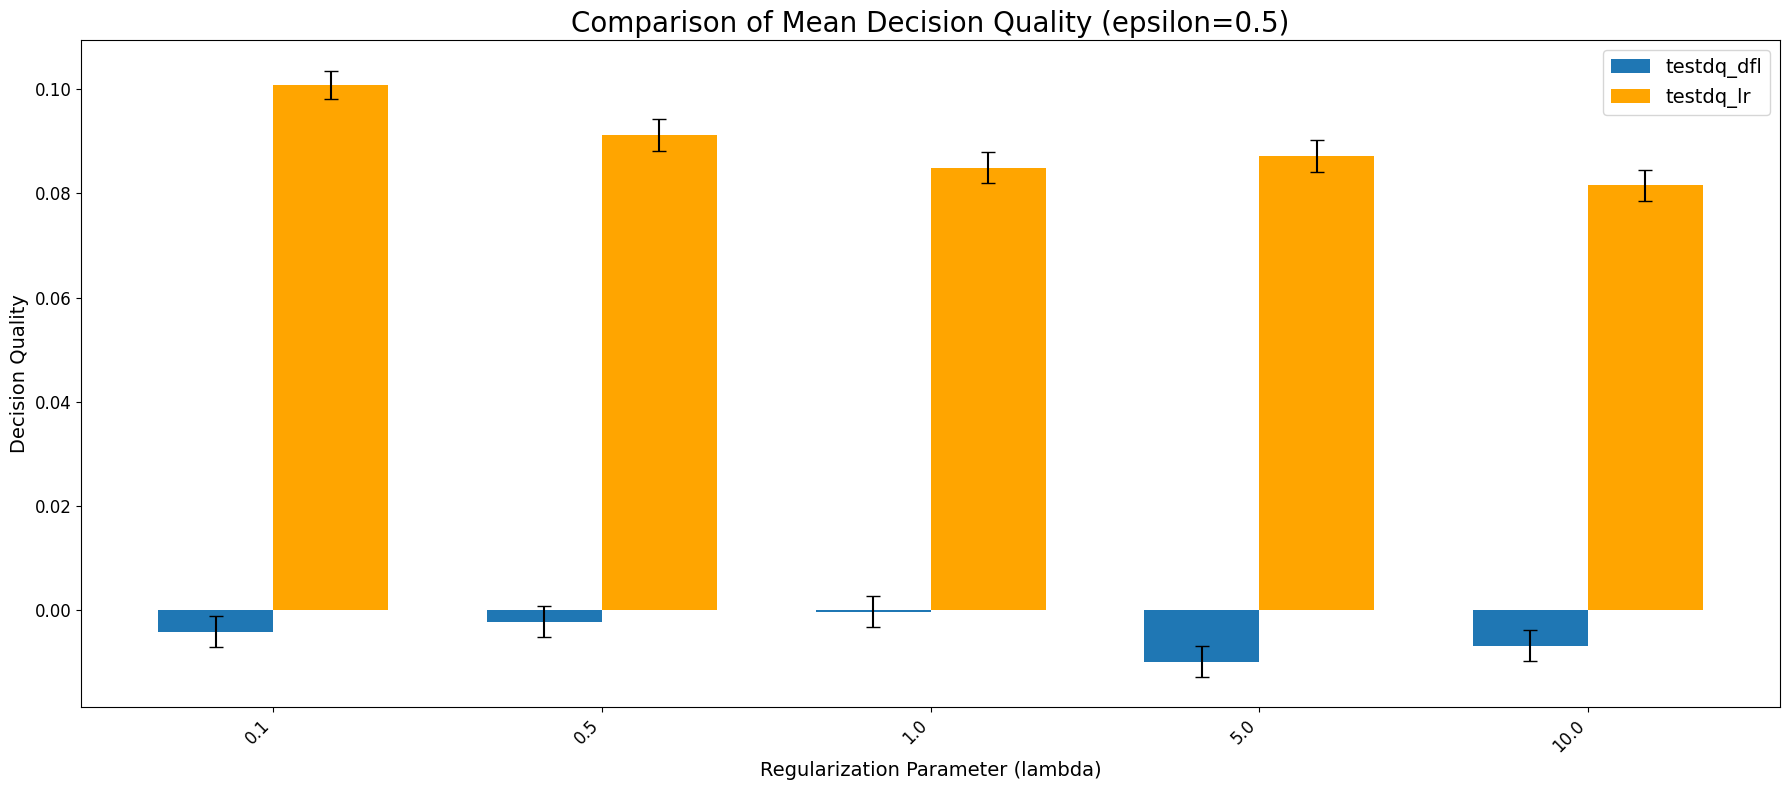

Shape of df_plot: (20000, 10)


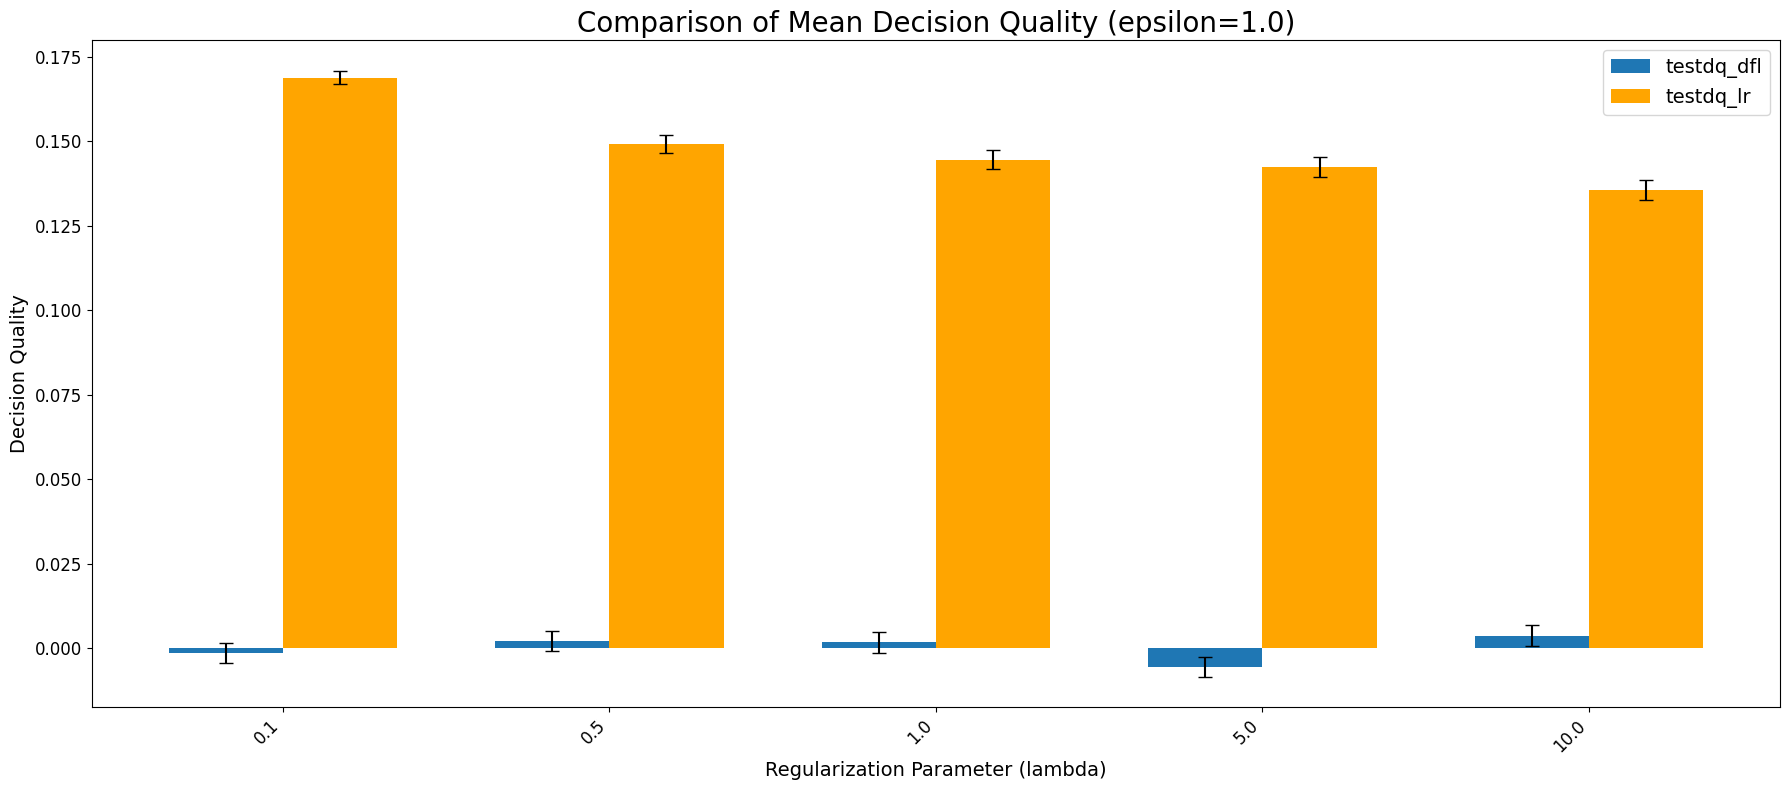

Shape of df_plot: (20000, 10)


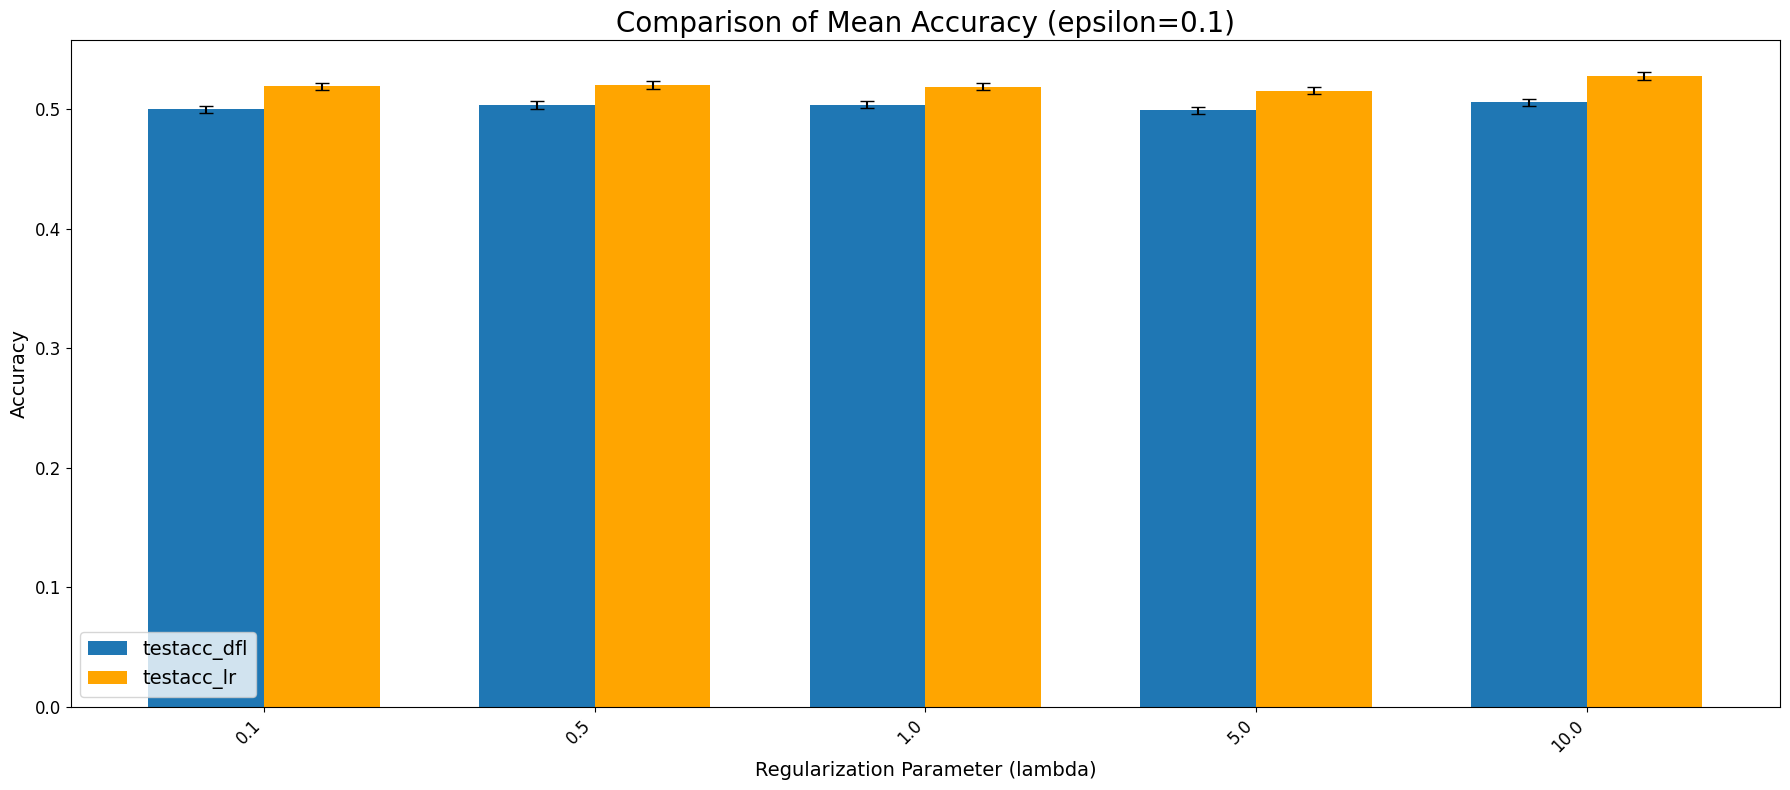

Shape of df_plot: (20000, 10)


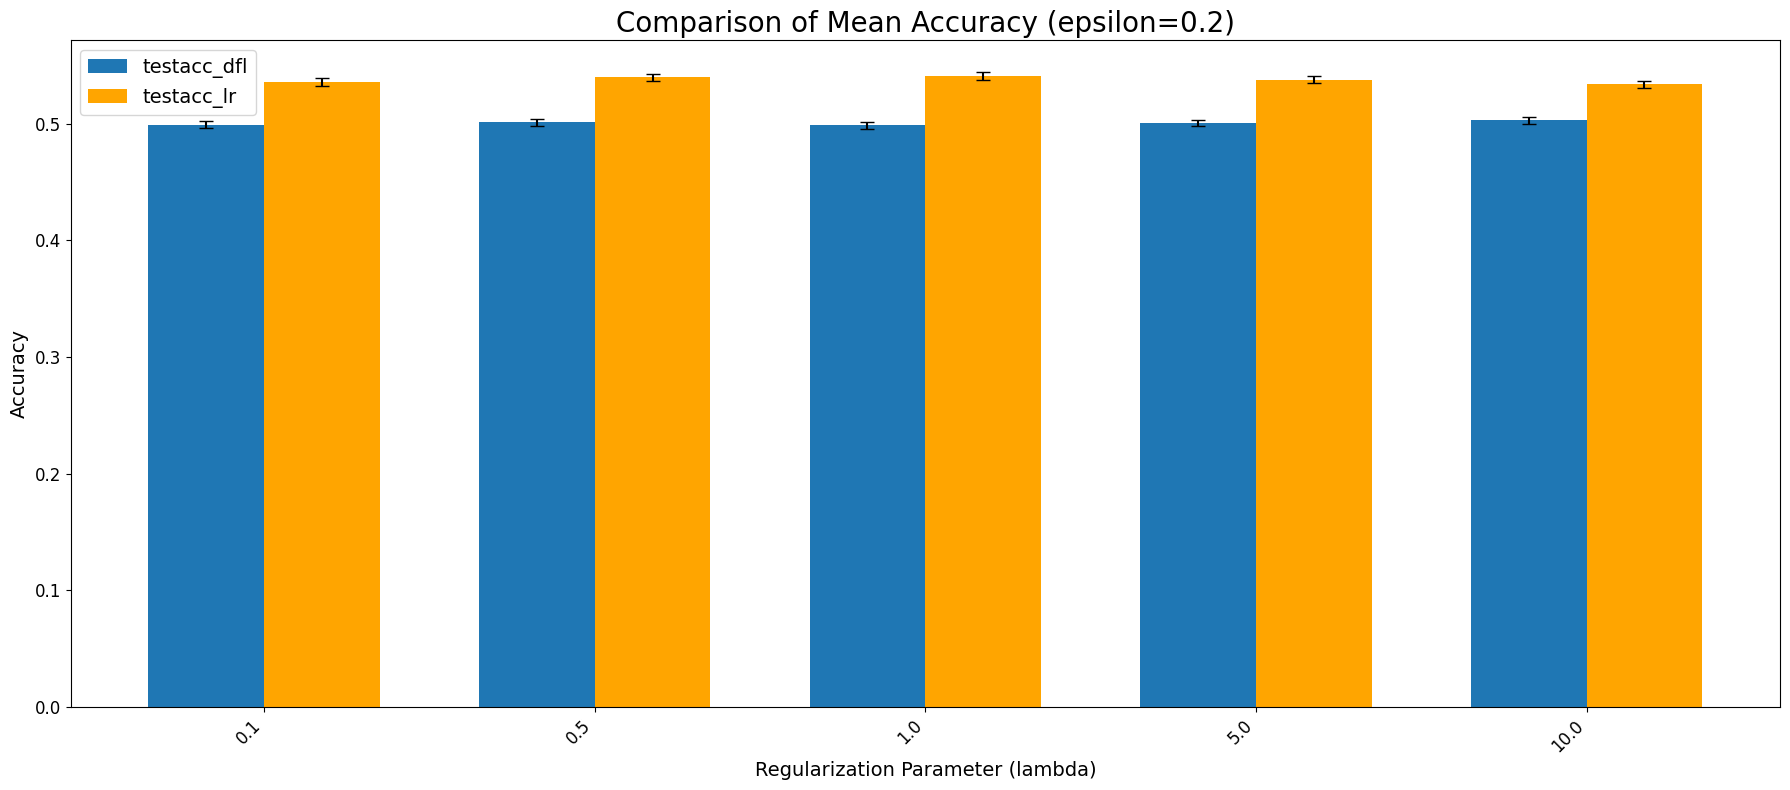

Shape of df_plot: (20000, 10)


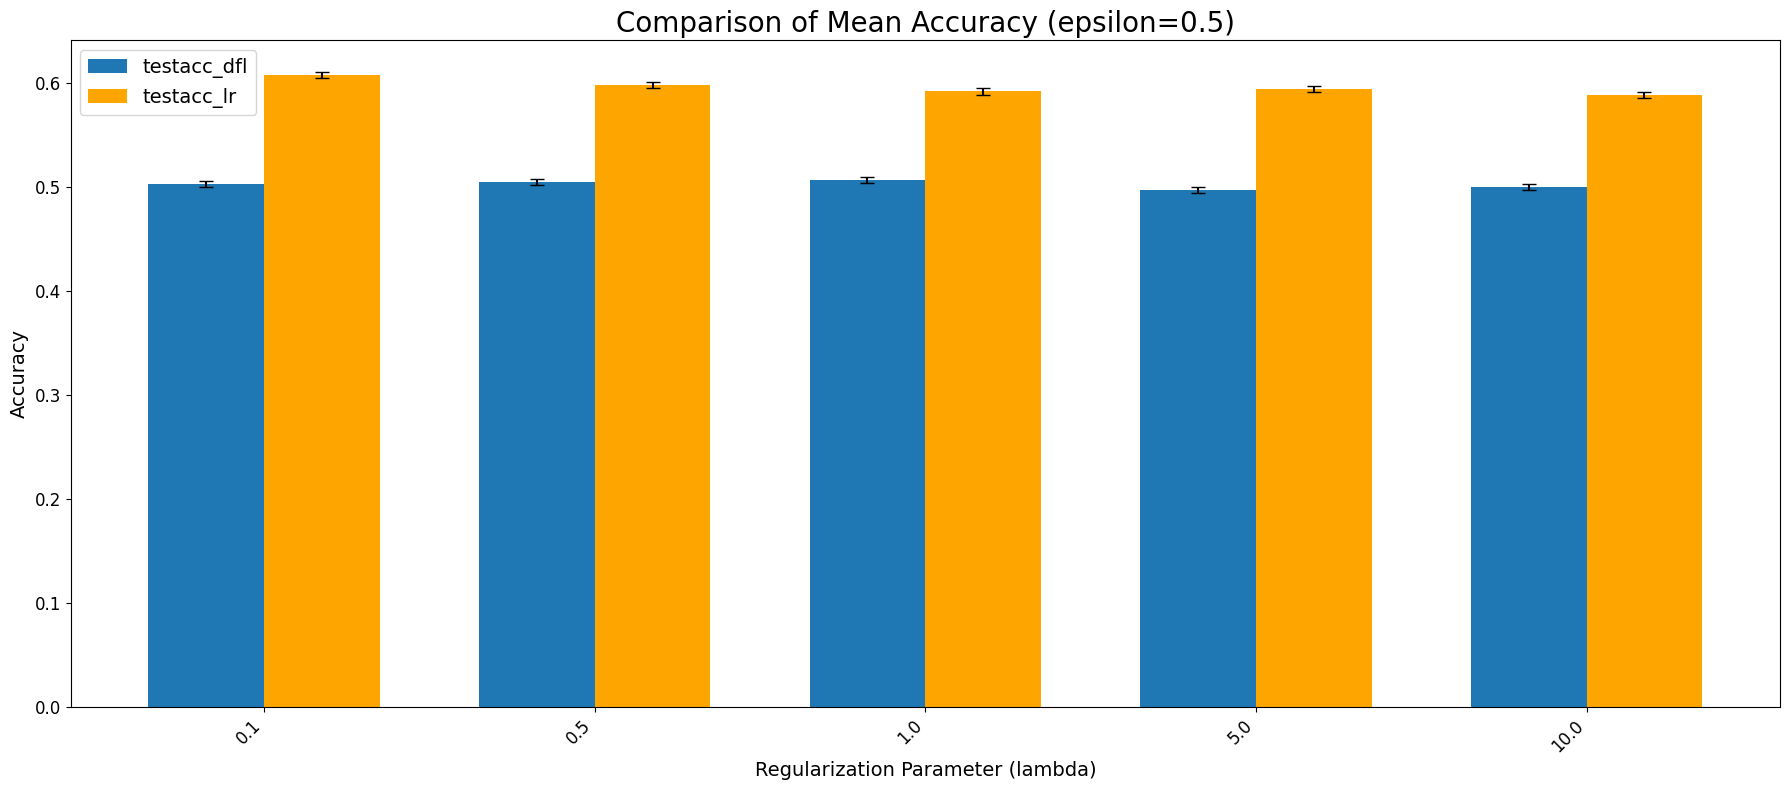

Shape of df_plot: (20000, 10)


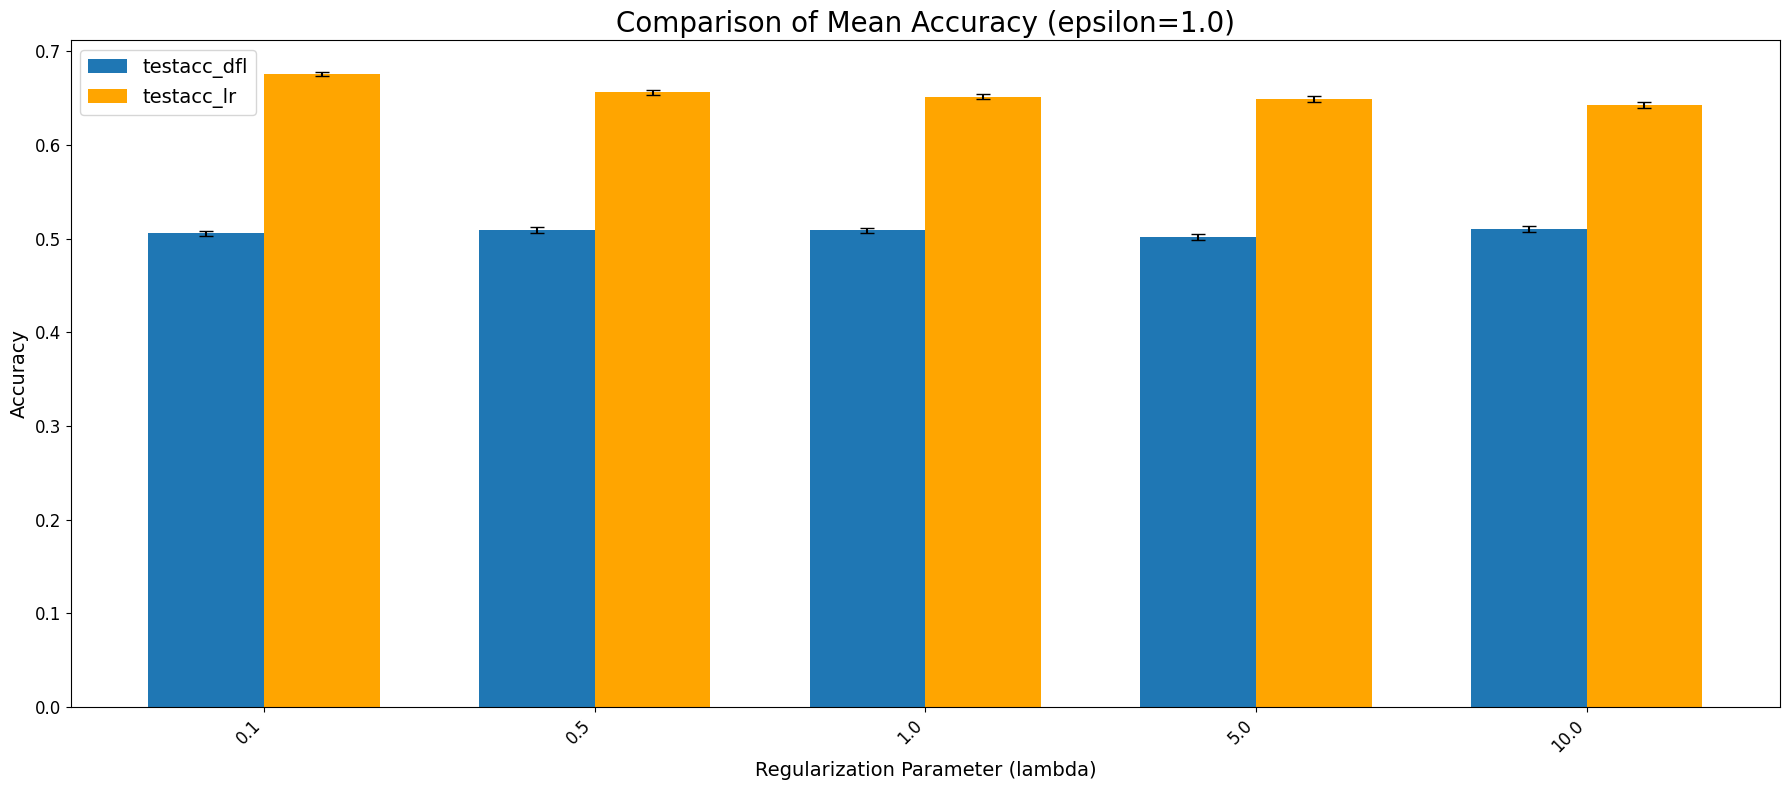

Shape of df_plot: (20000, 10)


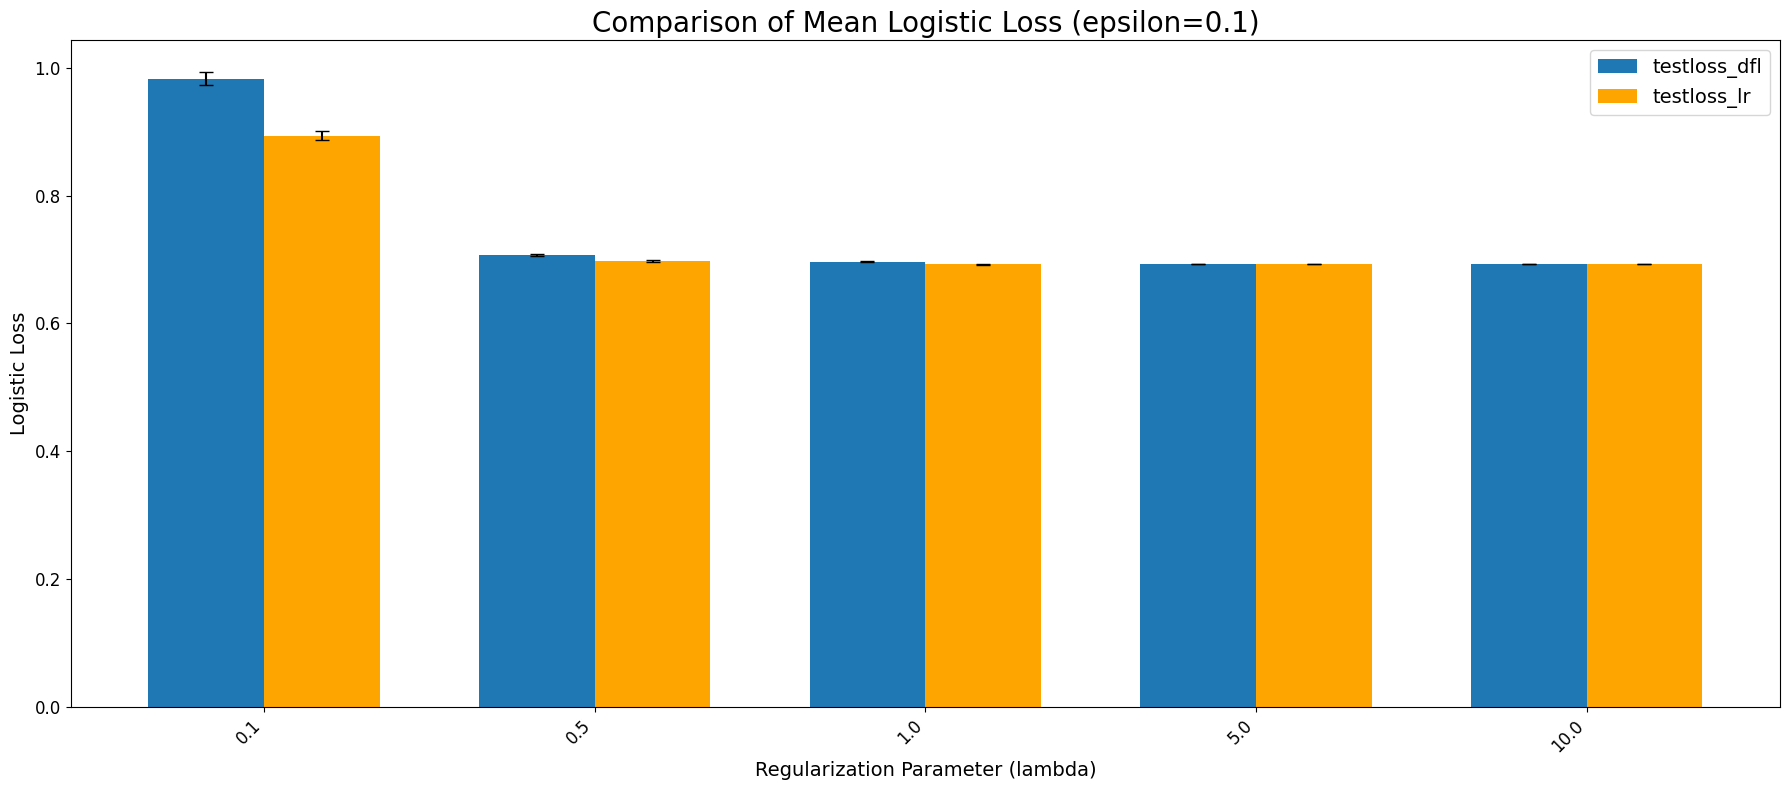

Shape of df_plot: (20000, 10)


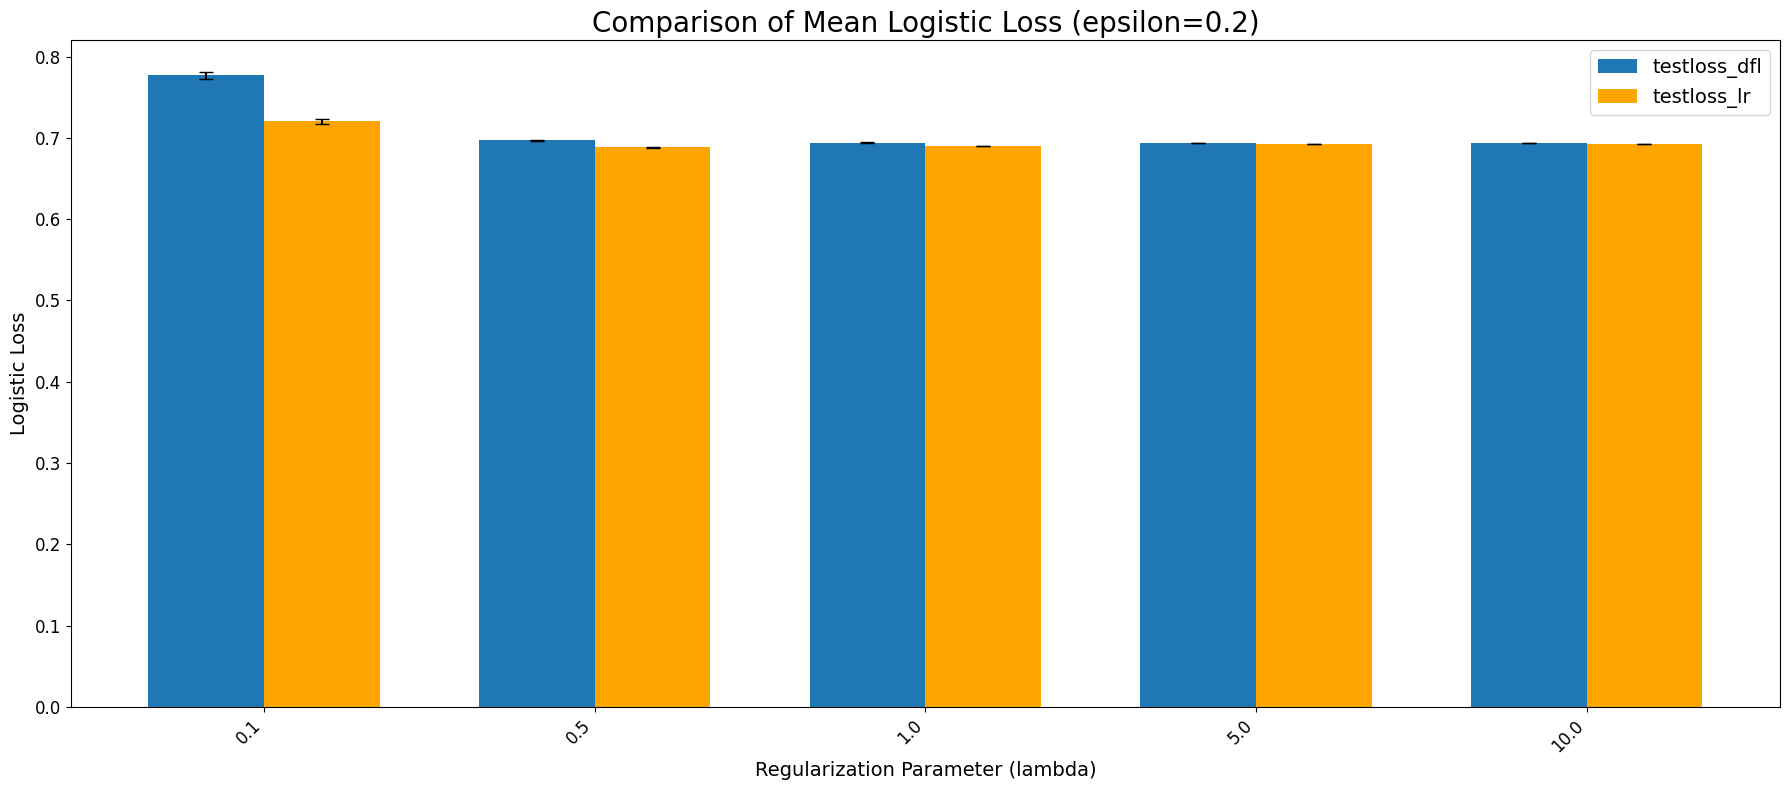

Shape of df_plot: (20000, 10)


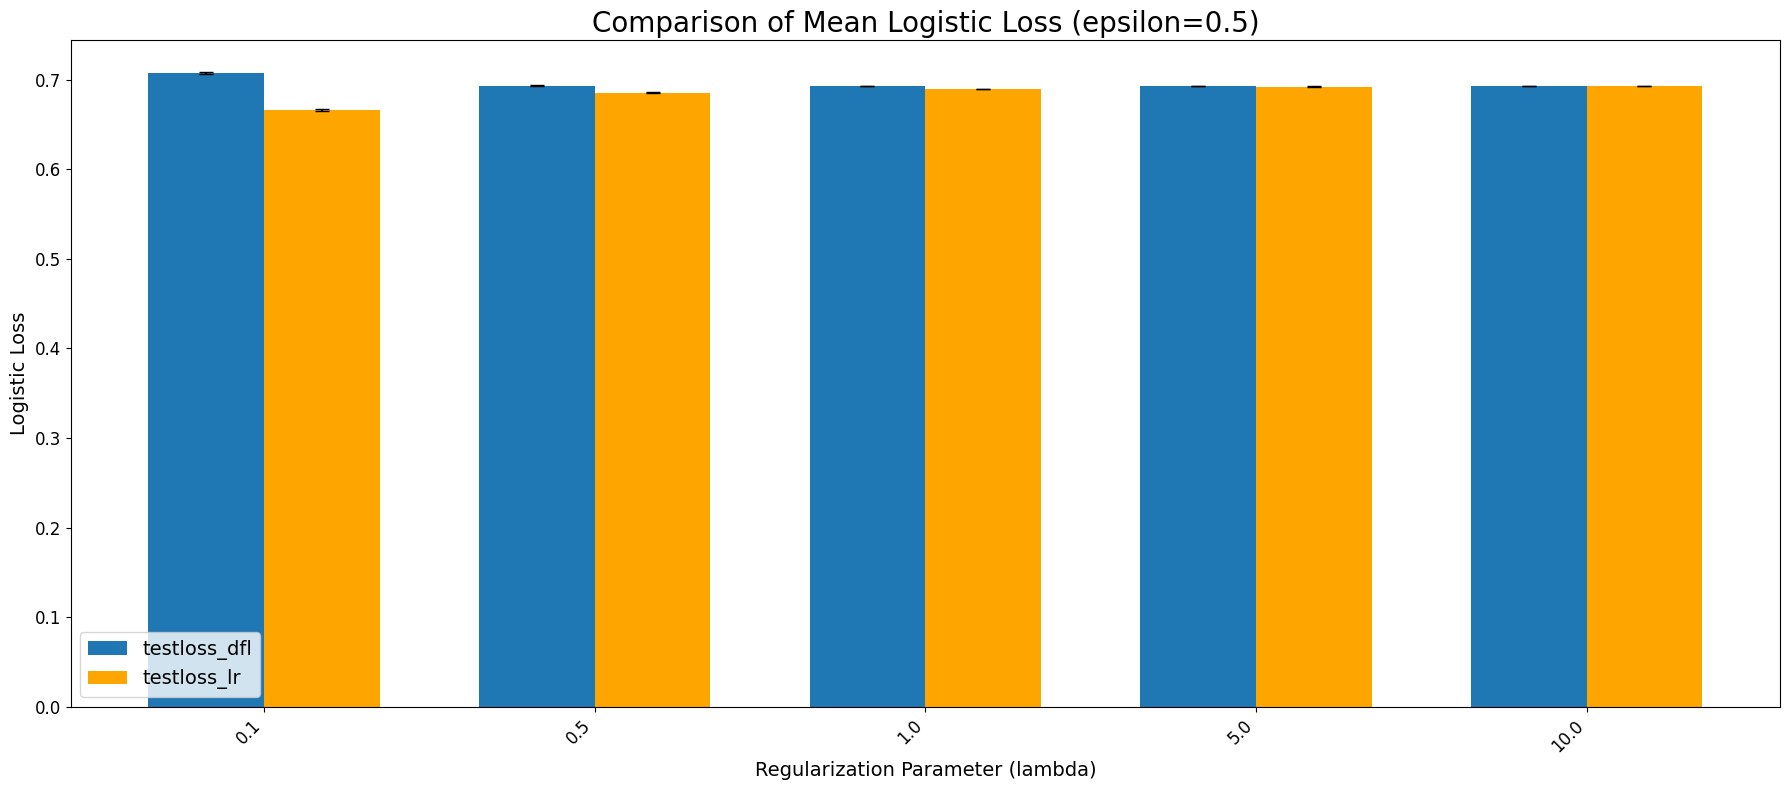

Shape of df_plot: (20000, 10)


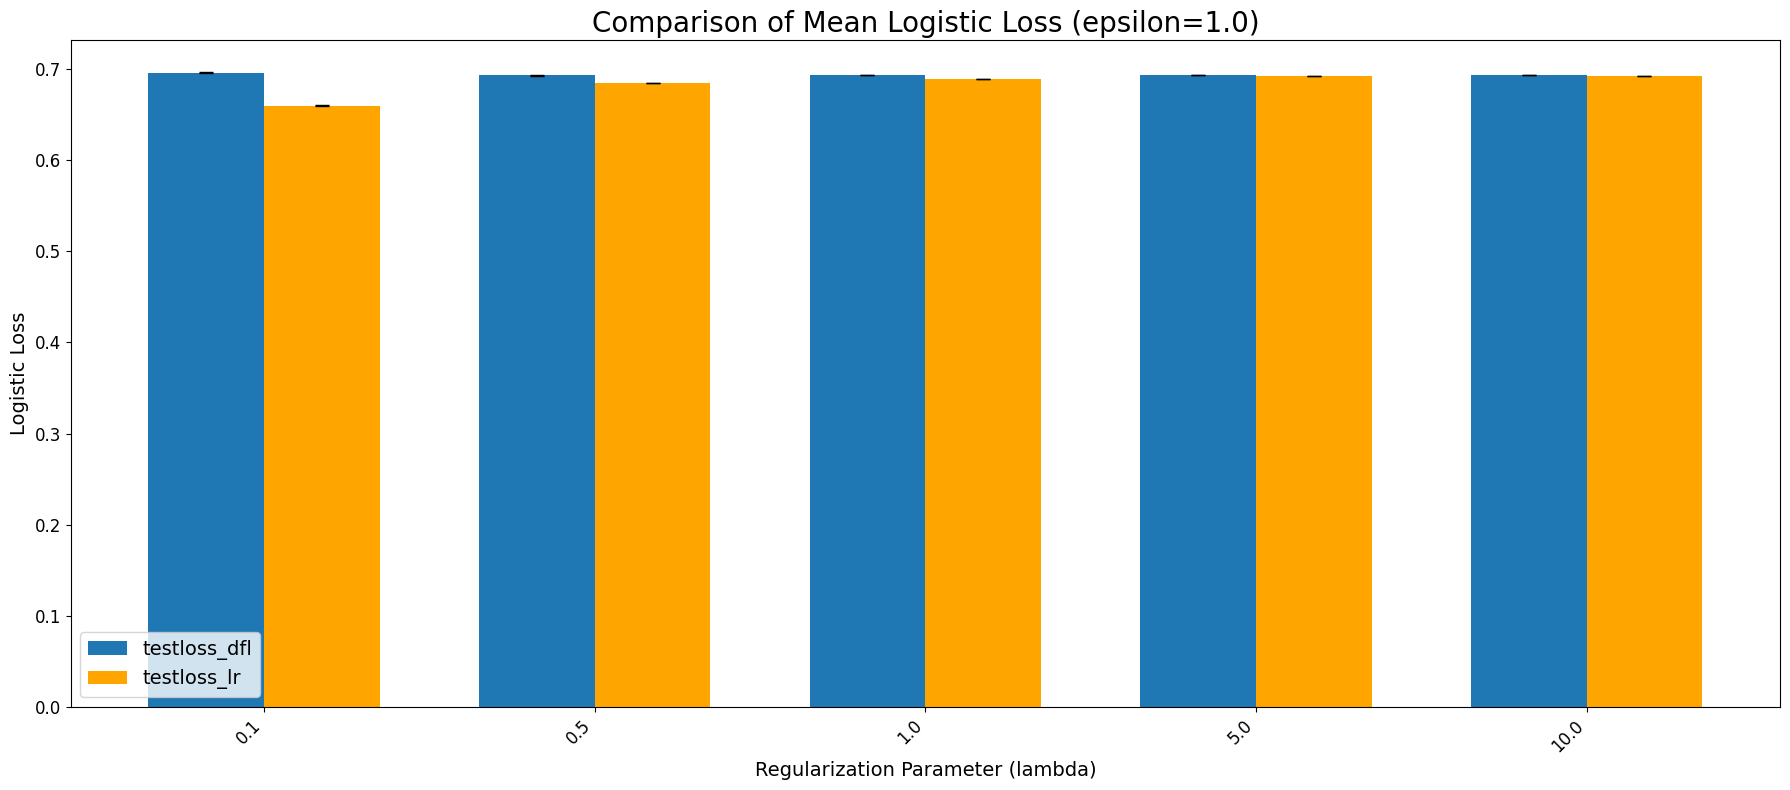

In [5]:
# SBATCH RESULTS
import os
import pandas as pd
from src.project_dirs import output_dir_name
from src.utils import plot_grouped_dq

filepath = str(output_dir_name('veqnoise_finer'))
print(filepath)

# List all files in the directory
files = os.listdir(filepath)
csv_files = [file for file in files if file.endswith('.csv')]
print(f"Number of .csv files: {len(csv_files)}")

file = os.path.join(filepath, csv_files[0])
df_all = pd.read_csv(file)

percentage = (df_all['testdq_dfl'] > df_all['testdq_lr']).mean() * 100
print(f"Percentage where DFL outperforms LR: {percentage:.2f}%")

percent = []
for k in df_all['key'].unique(): # check case by case for each key in which dfl is better
    df_k = df_all[df_all['key'] == k]
    percent.append((k, (df_k['testdq_dfl'] >= df_k['testdq_lr']).sum() / df_k.shape[0] * 100))

sorted_k = sorted(percent, key=lambda x: x[1], reverse=True)

cols_to_use = ['epsilon', 'lamb_dfl', 'lamb_lr', 'c_dfl', 'testloss_dfl', 'testdq_dfl', 'testloss_lr', 'testdq_lr', 'testacc_dfl', 'testacc_lr']

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testdq_dfl', 'lamb_lr', 'testdq_lr', metric='Decision Quality', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)


# Plot accuracy
plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testacc_dfl', 'lamb_lr', 'testacc_lr', metric='Accuracy', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)


# Plot loss
plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=0.1,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=0.2,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=0.5,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)

plot_grouped_dq(df_all, cols_to_use, 'lamb_dfl', 'testloss_dfl', 'lamb_lr', 'testloss_lr', metric='Logistic Loss', epsilon=1.0,
                title_fontsize=20, label_fontsize=14, tick_fontsize=12)





In [10]:
# SBATCH RESULTS
import os
import pandas as pd
from src.project_dirs import output_dir_name
import numpy as np
import math
from collections import Counter

filepath = str(output_dir_name('vfiner'))
print(filepath)

# List all files in the directory
files = os.listdir(filepath)

# Filter files ending with .ipynb
csv_files = [file for file in files if file.endswith('.csv')]


# Count the number of .ipynb files
print(f"Number of .ipynb files: {len(csv_files)}")

file = os.path.join(filepath, csv_files[0])
df_all = pd.read_csv(file)


percentage = (df_all['testdq_dfl'] > df_all['testdq_lr']).mean() * 100
print(f"Percentage where DFL outperforms LR: {percentage:.2f}%")



print(df_all.shape) # 100 runs each, 199 unique keys (espilon, lambda_dfl, lambda_lr)

# all c_dfl values where we see infinity (for loss typically)
display(dict(sorted(Counter(df_all[df_all.isin([math.inf, -math.inf]).any(axis=1)]['c_dfl']).items())))

# all c_df values for those rows where test decision quality for DFL > test decision quality for LR
display(dict(sorted(Counter(df_all[df_all['testdq_dfl'] > df_all['testdq_lr']]['c_dfl']).items())))

df_ninf = df_all[~df_all.isin([math.inf, -math.inf]).any(axis=1)]
print(df_ninf.shape)


df_ninf[df_ninf['testdq_dfl'] > df_ninf['testdq_lr']].shape[0] / df_ninf.shape[0] * 100




/home/kacharya33/dp4dfl/outputs/vfiner
Number of .ipynb files: 1
Percentage where DFL outperforms LR: 52.29%
(19900, 20)


{0.01: 889, 0.02: 643, 0.05: 365, 0.1: 193, 0.2: 71, 0.5: 5}

{0.01: 1113,
 0.02: 1160,
 0.05: 1145,
 0.1: 1150,
 0.2: 1141,
 0.5: 1163,
 1.0: 1219,
 2.0: 1156,
 5.0: 1158}

(17734, 20)


50.7781662343521

(19900, 20)


{0.01: 889, 0.02: 643, 0.05: 365, 0.1: 193, 0.2: 71, 0.5: 5}

{0.01: 1113,
 0.02: 1160,
 0.05: 1145,
 0.1: 1150,
 0.2: 1141,
 0.5: 1163,
 1.0: 1219,
 2.0: 1156,
 5.0: 1158}

(17734, 20)


50.7781662343521

In [32]:
df_bestDQ = df_all[df_all['key'] == 'eps0.1_lambdfl1.0_lamblr0.1']
display(df_bestDQ)
Counter(df_bestDQ['c_dfl'])

,run,key,epsilon,lamb_dfl,c_dfl,lamb_lr,w_dfl,w_lr,trainloss_dfl,trainacc_dfl,traindq_dfl,testloss_dfl,testacc_dfl,testdq_dfl,trainloss_lr,trainacc_lr,traindq_lr,testloss_lr,testacc_lr,testdq_lr
17600,0,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,5.00,0.1,25.666526,21.026553,0.920932,0.575,0.077,0.950246,0.547,0.040,0.745310,0.578,0.080,0.756919,0.551,0.044
17601,1,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,0.10,0.1,1203.584873,22.517436,24.943384,0.603,0.105,26.150780,0.594,0.087,0.990217,0.541,0.043,0.977948,0.537,0.030
17602,2,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,1.00,0.1,141.375231,18.294752,2.787390,0.536,0.038,2.990445,0.523,0.016,0.909707,0.506,0.008,0.880550,0.532,0.025
17603,3,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,0.02,0.1,5944.773494,19.349867,inf,0.621,0.123,inf,0.631,0.124,0.698066,0.586,0.088,0.707247,0.548,0.041
17604,4,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,0.01,0.1,12525.896179,18.626456,inf,0.597,0.099,inf,0.599,0.092,0.672950,0.642,0.144,0.660929,0.637,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17695,95,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,0.10,0.1,1381.918943,16.567082,16.697849,0.656,0.158,15.427156,0.672,0.165,0.689691,0.600,0.102,0.702262,0.598,0.091
17696,96,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,0.20,0.1,615.480969,21.949097,25.924604,0.531,0.033,27.855884,0.528,0.021,1.001705,0.439,-0.059,0.971163,0.451,-0.056
17697,97,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,0.02,0.1,6253.677959,25.125197,inf,0.597,0.099,inf,0.589,0.082,1.306630,0.396,-0.102,1.188750,0.413,-0.094
17698,98,eps0.1_lambdfl1.0_lamblr0.1,0.1,1.0,5.00,0.1,22.038313,19.471263,0.664226,0.626,0.128,0.703052,0.626,0.119,1.278654,0.430,-0.068,1.225989,0.443,-0.064


Counter({0.1: 20,
         1.0: 14,
         5.0: 12,
         0.02: 12,
         0.5: 11,
         0.2: 10,
         0.01: 8,
         0.05: 8,
         2.0: 5})

In [ ]:
# df_bestDQ = df_all[df_all['key'] == 'eps0.1_lambdfl1.0_lamblr0.1']
# df_bestDQ[['c_dfl', 'testloss_dfl', 'testdq_dfl', 'testloss_lr', 'testdq_lr']]

# # find rows where any of the elements have inf
# df_bestDQ[df_bestDQ.isin([math.inf, -math.inf]).any(axis=1)]

# # find rows where any of the elements have nan
# df_bestDQ[df_bestDQ.isin([math.inf]).any(axis=1)]
